In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np

#https://github.com/mozillazg/python-pinyin
from pypinyin import pinyin, lazy_pinyin, Style

import matplotlib
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate import bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def load_vocab(file_path):
    # load vocab.txt with \n at each line
    f = open(file_path,"r")
    lines = f.readlines()
    
    vocab = data_clean(lines)
    return vocab


def load_data(in_path, out_path, nb_couplets,with_all_couplets):
    couplet_in = open(in_path, "r")
    couplet_out = open(out_path, "r")

    # load original couplets
    lines_in = couplet_in.readlines()  # len = 770491
    lines_out = couplet_out.readlines()

    # clean samples
    samples_in = data_clean(lines_in)
    samples_out = data_clean(lines_out)

    # determine min and max length
    min_length = len(min(samples_in, key=len))
    max_length = len(max(samples_out, key=len))
    max_length +=  1
    print("min line length is ", min_length)
    print("max line length is ", max_length)
    # define data_in and data_out   => X and Ŷ  
    if (with_all_couplets == False):
        samples_in = samples_in[:nb_couplets]  # take some samples
        samples_out = samples_out[:nb_couplets]

    print("Loaded input couplets length is ",len(samples_in))
    print("Loaded output couplets length is ",len(samples_out))

    return samples_in, samples_out, max_length


# clean data
def data_clean(data):
    s=[]
    for i in range(0, len(data)):
        s.append(str(data[i]).replace('\n','').replace(' ','')) 
    return s


def data_clean_II(data):
    s=[]
    for i in range(0, len(data)):
        #l= str(data[i]).replace('\n','').strip('')
        l= str(data[i]).strip('\n').strip('？').strip('：').replace(' ','')
        if (l.find('，') == -1):
            s.append(l)
        else:
            l = l.split('，')
            for j in range(0, len(l)):  # seperate couplets ....................how to consider , ? !   :tjs there
                s.append(l[j])
    return s




##########

# create char2int dictionary
def create_char2int_and_int2char_dict(vocab):
    rang = np.arange(len(vocab))
    char2int_dict = dict(zip(vocab,rang))
    int2char_dict = dict(zip(rang,vocab))
    int2char_dict[0] = ''  # '' for pad
    return char2int_dict,int2char_dict


# create char2tone dictionary
def create_char2tone_dict(vocab):
    tone_dict = dict()
    tone_dict[vocab[0]]= ' '
    tone_dict[vocab[1]]= ' '
    tone_dict[vocab[2]]= ' '
    tone_dict[vocab[3]]= ' '
    for i in range(4,len(vocab)): # modify 3------------------------
        key = str(vocab[i])
        #print("key is", key)
        t = pinyin(key, style=Style.TONE3, heteronym=True)[0] # tones for the character
        #print("t is ", t)
        for j in range(len(t)):
            
            pz = str(t[j][-1])  # tone number
            #print("j",j)
            #print("pz ",pz)
            if ( pz!= (key) and pz.isdigit() ):  
                #print("-")
                if( int(pz) <= 2):
                    #print("--")
                    if (j==0):
                        #print("---")
                        tone_dict[key]=['P']
                        #print(tone_dict[key])
                    else:
                        tone_dict[key].append('P')  
                else:
                    if(j==0):
                        tone_dict[key]=['Z']
                    else:
                        tone_dict[key].append('Z')
            else: 
                if (tone_dict.get(key) == None):
                    tone_dict[key]=[' ']  # when there is no tone     # ， ？ ： 、 ； ！ - 屷 … 俬 〇 牗 -----
                
        
        tone_dict[key] = set(tone_dict[key])
        #print("tone_dict[key] set",tone_dict[key])
        tone_dict[key] = list(tone_dict[key])
        #print("tone_dict[key] list",tone_dict[key])
        res =''
        for k in range(len(tone_dict[key])):
            res += tone_dict[key][k]
        tone_dict[key] = res
    return tone_dict


    
# tokenize : couplet to int vectors
def tokenize(data, char2int_dict, max_length):  # data is sets of couplets
    v=[]
    for i in range(0, len(data)):
        l = []
        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        #v.append(torch.tensor(l, dtype=torch.long, device=device).view(-1, 1))
        v.append(l)
    return v


def tokenize_dec_in(data, char2int_dict, max_length):  # data is sets of couplets
    v=[]
    for i in range(0, len(data)):
        l = [char2int_dict.get('sos')]

        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        v.append(l)
        #v.append(torch.tensor(l, dtype=torch.long, device=device).view(-1, 1))
    return v


def tokenize_dec_out(data, char2int_dict, max_length):  # data is sets of couplets
    v=[]
    for i in range(0, len(data)):
        l = []
        for j in range (0, len(data[i])):
            if ( char2int_dict.get(data[i][j])  is None ):
                l.append(   char2int_dict.get('UNK')  )
            else:
                l.append(   char2int_dict.get(data[i][j])  )

        l.append(char2int_dict.get('eos'))
        if (len(data[i]) < max_length):   # padding 0(pad) at the end
            l = (l + [0] * max_length)[:max_length]
        #v.append(torch.tensor(l, dtype=torch.long, device=device).view(-1, 1))
        v.append(l)
    return v


##########

def detokenize(one_couplet, int2char_dict):
    o = ''
    for i in range(0, len(one_couplet)):
        if (one_couplet[i] >= 3):    # ignore pad,sos,eos
            o = o + int2char_dict.get(one_couplet[i].item())   # one_couplet should be like [24,576,134]
    return o
    

def detokenize_II(one_couplet, int2char_dict,n):
    o = ''
    n = min(len(one_couplet),n)
    for i in range(0, n):
        if (couplet[i] >= 3):    # ignore pad,sos,eos
            o = o + int2char_dict.get(one_couplet[i].item())  

    return o
    
def detokenize_All(couplets, int2char_dict):
    o = ''
    for i in range(0, len(couplets)):
        for j in range(len(couplets[i])):
            if (couplets[i][j] >= 3):    # ignore pad,sos,eos
                o = o + int2char_dict.get(couplets[i][j].item()) 
        o = o +"\n"
    return o



# create a dictionary of repeted words
def dict_repet_idx(one_tensor,length):
    records_array = np.array(one_tensor)[:length]
    vals, inverse, count = np.unique(records_array, return_inverse=True,return_counts=True)
    idx_vals_repeated = np.where(count > 1)[0]
    vals_repeated = vals[idx_vals_repeated]

    rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
    _, inverse_rows = np.unique(rows, return_index=True)
    res = np.split(cols, inverse_rows[1:])
    
    d = dict()
    for i in range(len(res)):
        for l in range(1,len(res[i])):
            val = res[i][0]
            d[ res[i][l] ]  = val
    
    return d


# save locally
def write_to(path,words):
    f = open(path,"w")
    f.write(words)
    f.write('\n')
    f.close

In [3]:
##########################
#####humain start#########
##########################

In [4]:
def prepare_data(in_path,out_path,with_all_couplets=True):
    batch_size = 1 # ------------
    nb_couplets = 1024
    
    print("### data preparing ### ")
    print("Batch size is: ",batch_size)
    print("Use all couplets to train: ",with_all_couplets)
    if (with_all_couplets==False):
        print("\tTherefore nb_couplets to train is: ",nb_couplets)

    print("### data loading ### ")
    vocab_path = "./vocab_total_ori.txt"
    data_in, data_out, max_length = load_data(in_path,out_path,nb_couplets,with_all_couplets)
    vocab = load_vocab(vocab_path)
    vocab_size = len(vocab)
    print("Vocab length is ", vocab_size)
    return data_in,data_out,vocab,max_length

def create_dicts(data_in,data_out,vocab,max_length):

    # create char2int and int2char_dict
    char2int_dict, int2char_dict = create_char2int_and_int2char_dict(vocab)
    
    char2tone_dict = create_char2tone_dict(vocab)
    
    int2tone_dict = dict()
    for i in range(len(vocab)):
        t = char2tone_dict.get(vocab[i])
        int2tone_dict[i] = t

    return char2int_dict, int2char_dict, char2tone_dict, int2tone_dict
        
        
def create_tone_mask(vocab, char2tone_dict):
    tone_onlyP_2 = np.ones(len(vocab))
    tone_onlyZ_2 = np.ones(len(vocab))
    for i in range(len(vocab)):
        # i  <=> char_id   
        tone = char2tone_dict.get(vocab[i])
        if (tone.isalpha()):
            if (len(tone) != 2):
                if(tone == 'P'):
                    tone_onlyP_2[i] = 92233720368547758
                else:
                    tone_onlyZ_2[i] = 92233720368547758
    return tone_onlyP_2, tone_onlyZ_2

def tokenization(data_in,data_out,char2int_dict,max_length):
    # Line One from character to int
    Enc_in =  tokenize(data_in,char2int_dict,max_length)
    # Line two from character to int, with SOS and EOS
    token_out =tokenize(data_out,char2int_dict,max_length)
    Dec_in = tokenize_dec_in(data_out,char2int_dict,max_length)
    Dec_out = tokenize_dec_out(data_out,char2int_dict,max_length)  
    
    return  Enc_in,Dec_in,Dec_out

def prepare_batches(Enc_in,Dec_out,Dec_in,batch_size=1):
    in_ = []
    for i in range(0,int(len(Enc_in)/batch_size)):
        in_.append( torch.Tensor(Enc_in[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    out_ = []
    for i in range(0,int(len(Dec_out)/batch_size)):
        out_.append( torch.Tensor(Dec_out[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    dec_in_ =[]
    for i in range(0,int(len(Dec_in)/batch_size)):
        dec_in_.append( torch.Tensor(Dec_in[batch_size*i:batch_size*(i+1)]).to(torch.int64) )
    batch_in_out_pairs =[]   # may ignore some last couplets
    for i in range(0, len(in_)):
        batch_in_out_pairs.append((in_[i],dec_in_[i], out_[i]))
    print("Number of couplet batches :",len(batch_in_out_pairs))
    
    return batch_in_out_pairs


from copy import deepcopy

class Node:
    def __init__(self,indices,acc,hid,attn):
        self.indices = indices
        self.acc = acc
        self.hid = hid
        self.attn = attn

        
    def add_vi(self,val_,idx_,hid,attn):
        self.indices.append(idx_)
        self.acc = val_
        self.hid.append(hid)
        self.attn.append(attn)
    
        
    
    def printf(self):
        print("=> In Node:")
        print("=> Acc is: ",float(self.acc))
        print("=> Indices are:", [i for i in self.indices])

def detokenize_All(couplets, int2char_dict):
    o = ''
    for i in range(0, len(couplets)):
        for j in range(len(couplets[i])):
            if (couplets[i][j] >= 3):    # ignore pad,sos,eos
                o = o + int2char_dict.get(couplets[i][j].item()) 
        #o = o +"\n"
    return o

def detokenize_int(one_couplet, int2char_dict):
    o = ''
    for i in range(0, len(one_couplet)):
        if(int2char_dict.get(one_couplet[i]) is not None):
            o = o + int2char_dict.get(one_couplet[i])   # one_couplet should be like [24,576,134]
        else:
            print("what")
    return o


# create a dictionary of repeted words
def dict_repet_idx(one_tensor,length):
    records_array = np.array(one_tensor)[:length]
    vals, inverse, count = np.unique(records_array, return_inverse=True,return_counts=True)
    idx_vals_repeated = np.where(count > 1)[0]
    vals_repeated = vals[idx_vals_repeated]

    rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
    _, inverse_rows = np.unique(rows, return_index=True)
    res = np.split(cols, inverse_rows[1:])
    
    d = dict()
    for i in range(len(res)):
        for l in range(1,len(res[i])):
            val = res[i][0]
            d[ res[i][l] ]  = val
    
    return d



def detokenize_int_repet(input_tensor, one_couplet, int2char_dict):
    o = ''
    longueur = np.where(np.array(input_tensor[0]) == 0)[0][0]
    d = dict_repet_idx(input_tensor[0],longueur)
    #print("Input length is ",longueur)
    
    for i in range(0, len(one_couplet)):
        idx = d.get(i)
        if ( idx is not None ):
            # use the first appreared word
            o = o + int2char_dict.get(one_couplet[idx])
        else:
            o = o + int2char_dict.get(one_couplet[i])
    return o

def model_in(i,j):
    l=[]
    l.append(Enc_in[i])
    #l.append(Enc_in[i])
    #l.append(Enc_in[j])
    #l.append(Enc_in[j])
    #l.append(Enc_in[j])
    l = torch.Tensor(l).to(torch.int64)
    q=[]
    q.append(Dec_in[i])
    #q.append(Dec_in[i])
    #q.append(Dec_in[j])
    #q.append(Dec_in[j])
    #q.append(Dec_in[j])
    q = torch.Tensor(q).to(torch.int64)
    return l,q


### evaluate one couplet
def evaluate(char2tone_dict,encoder, decoder,input_tensor,forced_tone=True,forced_word=True, beam_width=1, max_length=33):
    
    batch_size = input_tensor.size(0)
    target_length = input_tensor.size(1)
    
    encoder.eval()
    decoder.eval()
    
    longueur = [np.where(np.array(input_tensor[0]) == 0)[0][0]]
    with torch.no_grad():
        encoder_hidden = torch.zeros(2, batch_size, hidden_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden,longueur)
        decoder_input = torch.tensor([1])
        decoder_hidden = encoder_hidden
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input.to(device), decoder_hidden.to(device), encoder_outputs.to(device))
        
        if(forced_tone):
            tone = int2tone_dict.get(int(input_tensor[0][0]))
            if( tone is not None and tone.isalpha() and len(tone) != 2 ):

                if (tone == 'P'):
                    decoder_output = decoder_output*torch.Tensor(tone_onlyP_2)
                else:
                    decoder_output = decoder_output*torch.Tensor(tone_onlyZ_2)        
        
        
        topv, topi = decoder_output.squeeze(1).topk(beam_width)
        
        decoder_input = topi.detach().t() # t() for convenience dec_in shape
        
        list_nodes = []
        init_node = Node( [], 0,[],[])  # indices,acc,hid,attn
        for l in range(0,beam_width):
            node = deepcopy(init_node)
            node.add_vi(topv[0][l],int(topi[0][l]),decoder_hidden,decoder_attention)
            list_nodes.append(node)  

        for j in range (1,longueur[0]):
            temp_val = []
            temp_idx = []
            temp_hid = []
            temp_attn = []
            for b in range(beam_width):
                decoder_output, decoder_hidden, decoder_attention = decoder(torch.tensor([ list_nodes[b].indices[-1] ]), list_nodes[b].hid[-1], encoder_outputs)
                
                if(forced_tone):
                    tone = int2tone_dict.get(int(input_tensor[0][j]))
                    if( tone is not None and tone.isalpha() and len(tone) != 2 ):

                        if (tone == 'P'):
                            decoder_output = decoder_output*torch.Tensor(tone_onlyP_2)  
                        else:
                            decoder_output = decoder_output*torch.Tensor(tone_onlyZ_2) 
                            
                
                topv, topi = decoder_output.squeeze(1).topk(beam_width)
                
                temp_val.append(topv) 
                temp_idx.append(topi)
                temp_hid.append(decoder_hidden)
                temp_attn.append(decoder_attention)
                
            for bb in range(beam_width):
                temp_val[bb] += list_nodes[bb].acc 
            
            concat = temp_val[0]
            concat_idx = temp_idx[0]
            concat_hid = []
            concat_hid.append(temp_hid[0])
            concat_attn = []
            concat_attn.append(temp_attn[0])
            for bbb in range(1,beam_width):
                concat = torch.cat((concat,temp_val[bbb]),dim=1)
                concat_idx = torch.cat((concat_idx,temp_idx[bbb]),dim=1)
                concat_hid.append(temp_hid[bbb])
                concat_attn.append(temp_attn[bbb])
            concat = concat.squeeze()
            concat_idx = concat_idx.squeeze()
            if(beam_width == 1):
                concat = concat.unsqueeze(0)
                concat_idx = concat_idx.unsqueeze(0)

            tv, ti = concat.topk(beam_width)

            new_list_nodes = []
            for bbbb in range(beam_width):
                quel_node =  int(int(ti[bbbb]) / beam_width)
                corr_nodes = list_nodes[quel_node] 

                new = deepcopy(corr_nodes)
                new.add_vi(concat[ti[bbbb]], int(concat_idx[ti[bbbb]]),concat_hid[quel_node],concat_attn[quel_node] )

                new_list_nodes.append(deepcopy(new))

            new_dec_in = []
            for e in range(len(new_list_nodes)):
                nn = new_list_nodes[e]
                new_dec_in.append(nn.indices[-1])
            new_dec_in = torch.tensor(new_dec_in).unsqueeze(1)
            
            list_nodes = deepcopy(new_list_nodes)
            decoder_input = new_dec_in

        decoded_words=[]
        for kk in range(len(list_nodes)):
            nnn = list_nodes[kk]
            d = nnn.indices
            
            if (forced_word):
                decoded_words.append( detokenize_int_repet(input_tensor, d, int2char_dict) )
            else:
                decoded_words.append( detokenize_int(d, int2char_dict) )
    return decoded_words, list_nodes
            
# evaluate randomly n couplets
def evaluateRandomly(char2tone_dict,encoder, decoder,forced_tone=True,forced_word=False,beam_width=1, n=1):

    for i in range(n):
        
        i = np.random.randint(len(Enc_in))
        
        j = np.random.randint(len(Enc_in))
        pair, d_out = model_in(i,j)
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        
        print("in: ")
        inn = detokenize_All(pair, int2char_dict)
        print(inn)
        print('model answer: ')
        print(output_words_line)
        print("desired answer: ")
        outt = detokenize_All(d_out, int2char_dict)
        print(outt)
        print("\n")
        
        
        # If you want to plot the attention
        # Decomment the following code
        #"""""
        attn = []
        for w in range(len(list_nodes)):
            #print("w is ",w)
            a = list_nodes[w].attn
            #print("len attn",len(a))
            attn_tmp = torch.tensor(())
            for m in range(len(a)):
                b = torch.tensor(a[m][0])
                #plt.subplots(figsize=(5, 9))
                #plt.imshow(b,cmap='hot')
                #plt.show()
                attn_tmp = torch.cat((attn_tmp, b),0) 
                
            #showAttention(pair, output_words[k], list_nodes[k].attn)
            #print("tmp shape",attn_tmp.shape)  # for j in longueur or max_length
            
            plt.subplots(figsize=(3, 2))
            #plt.imshow(attn_tmp[:8,:8],cmap='hot')
            plt.imshow(attn_tmp,cmap='hot')

            plt.colorbar()
            plt.show()
            attn.append(attn_tmp)
        #"""""
    
### bleu and attn ###
def compute_bleu(char2tone_dict,encoder, decoder,forced_tone=False,forced_word=False,beam_width=1, n=1):
    total_bleu = 0
    count=0
    #for i in range(len(batch_in_out_pairs_eval)):
    for i in range(n):#len(batch_in_out_pairs_eval)):
        
        if ( i % int(0.1*n) == 0):
            print( i / n)
        #print("idx is ",i)
        
        j = np.random.randint(len(Enc_in))
        pair, d_out = model_in(i,j)
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        inn = detokenize_All(pair, int2char_dict)
        outt = detokenize_All(d_out, int2char_dict)
       
        for k in range(len(output_words)):
            smoothie = SmoothingFunction().method4
            if( len(outt) == 1 and outt==output_words[k]):  # otherwise division 0
                total_bleu += 1.0
                count+=1
            else:
                b = bleu([outt], output_words[k], smoothing_function=smoothie)
                total_bleu += b
                if(b >= 0.2):
                    count+=1
                    
    print("## FIN ##")
    print("BLEU :",total_bleu/ (n*beam_width)  )
    print("#count >0.2 :",count/beam_width)        
        
# need data_in, data_out, Enc_in Dec_out
def for_humain_eval(i,n,pt,char2tone_dict,indices,om,forced_tone=True,forced_word=False,beam_width=1):
    encoder = torch.load("./models/II_enc_epoch_"+pt+".pt",map_location='cpu')
    attn_decoder = torch.load("./models/II_dec_epoch_"+pt+".pt",map_location='cpu')
    encoder.eval()
    attn_decoder.eval()
    print("encoder.hidden_size:",encoder.hidden_size)
    print("attn_decoder.hidden_size:",attn_decoder.hidden_size)

    f = open("./random_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    f_oomm = open("./random_oomm_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    f_a = open("./random_notes_"+str(i)+"_"+pt+"_"+str(forced_tone)+"_"+str(forced_word)+"_"+str(beam_width)+".txt","w")
    
    
    f_a.write("### oo => 0, mm => 1 ###")
    f_a.write("\n")
    
    for idx in range(n):
        
        f_a.write("-Question-"+str(idx+1)+"\n")
        f_a.write("Indices:"+str(indices[idx])+"\n")
        f_a.write("Truth:"+str(om[idx])+"\n")
        f_a.write("\n")
    
        # generate model answer
        i = indices[idx]
        pair = torch.Tensor(Enc_in[i]).to(torch.int64).unsqueeze(0)
        d_out = torch.Tensor(Dec_in[i]).to(torch.int64).unsqueeze(0)
        output_words, _ = evaluate(char2tone_dict,encoder, attn_decoder, pair,forced_tone,forced_word,beam_width)
        
        # without oomm 
        f.write("-Question-"+str(idx+1)+"\n")
        f.write("Indices:"+str(i)+"\n")
        f.write(data_in[i]+" ii\n")
        if(om[idx] == 0):
            f.write(data_out[i]+"\n")
            f.write(output_words[0]+"\n")
        else:
            f.write(output_words[0]+"\n")
            f.write(data_out[i]+"\n")
        f.write('\n')
        
        # with oomm    
        f_oomm.write("-Question-"+str(idx+1)+"\n")
        f_oomm.write("Indices:"+str(i)+"\n")
        f_oomm.write(data_in[i]+" ii\n")   
        if(om[idx] == 0): 
            f_oomm.write(data_out[i]+" oo\n")
            f_oomm.write(output_words[0]+" mm\n")
        else:
            f_oomm.write(output_words[0]+" mm\n")
            f_oomm.write(data_out[i]+" oo\n")            
        f_oomm.write('\n')
        
    f_a.close
    f.close
    f_oomm.close

In [5]:
in_path = "./test_in_remov.txt"
out_path = "./test_out_remov.txt"

In [6]:
hidden_size = 256
data_in,data_out,vocab,max_length = prepare_data(in_path,out_path,with_all_couplets=True)
char2int_dict, int2char_dict, char2tone_dict, int2tone_dict = create_dicts(data_in,data_out,vocab,max_length)
tone_onlyP_2, tone_onlyZ_2 = create_tone_mask(vocab, char2tone_dict)
Enc_in,Dec_in,Dec_out = tokenization(data_in,data_out,char2int_dict,max_length)
batch_in_out_pairs_eval = prepare_batches(Enc_in,Dec_out,Dec_in,batch_size=1)

### data preparing ### 
Batch size is:  1
Use all couplets to train:  True
### data loading ### 
min line length is  1
max line length is  32
Loaded input couplets length is  3931
Loaded output couplets length is  3931
Vocab length is  9131
Number of couplet batches : 3931


In [9]:
n=50

In [11]:
for i in range(10,20):
    indices = np.random.choice(len(Enc_in), n, replace = False)
    om = np.random.choice(2, n, replace = True)
    for_humain_eval(i,n,"203",char2tone_dict,indices,om,forced_tone=True,forced_word=True,beam_width=3)

encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256
encoder.hidden_size: 256
attn_decoder.hidden_size: 256


In [9]:
encoder = torch.load("./models/II_enc_epoch_203.pt",map_location='cpu')
attn_decoder = torch.load("./models/II_dec_epoch_203.pt",map_location='cpu')
encoder.eval()
attn_decoder.eval()
print()

In [10]:
# evaluate randomly n couplets
def evaluateRandomly(char2tone_dict,encoder, decoder,forced_tone=True,forced_word=False,beam_width=1, n=1):
    f = open("./cou_attn.txt","a")
    for i in range(n):
        
        i = np.random.randint(len(Enc_in))
        
        j = np.random.randint(len(Enc_in))
        pair, d_out = model_in(i,j)
        output_words, list_nodes = evaluate(char2tone_dict,encoder, decoder, pair,forced_tone,forced_word,beam_width)
        output_words_line = '\n'.join(output_words)
        f.write(str(i))
        f.write("\n")
        print("in: ")
        inn = detokenize_All(pair, int2char_dict)
        print(inn)
        f.write(inn)
        f.write("\n")
        print('model answer: ')
        print(output_words_line)
        f.write(output_words_line)
        f.write("\n")
        print("desired answer: ")
        outt = detokenize_All(d_out, int2char_dict)
        print(outt)
        f.write(outt)
        f.write("\n")
        print("\n")
        
        
        # If you want to plot the attention
        # Decomment the following code
        #"""""
        attn = []
        for w in range(len(list_nodes)):
            #print("w is ",w)
            a = list_nodes[w].attn
            #print("len attn",len(a))
            attn_tmp = torch.tensor(())
            for m in range(len(a)):
                b = torch.tensor(a[m][0])
                #plt.subplots(figsize=(5, 9))
                #plt.imshow(b,cmap='hot')
                #plt.show()
                attn_tmp = torch.cat((attn_tmp, b),0) 
                
            #showAttention(pair, output_words[k], list_nodes[k].attn)
            #print("tmp shape",attn_tmp.shape)  # for j in longueur or max_length
            
            plt.subplots(figsize=(5, 9))
            #plt.imshow(attn_tmp[:8,:8],cmap='hot')
            plt.imshow(attn_tmp,cmap='hot')
            
            plt.savefig('cou_'+str(i)+'.png')

            plt.colorbar()
            plt.show()
            attn.append(attn_tmp)
        #"""""

in: 
心随花影动
model answer: 
梦伴月光移
desired answer: 
月送玉人来




/home/xzou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


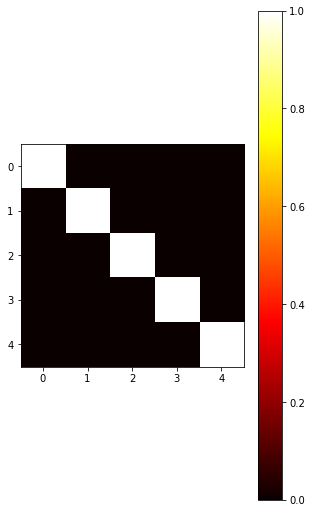

in: 
笑人修媚骨
model answer: 
花事落红尘
desired answer: 
惊我荡俗尘




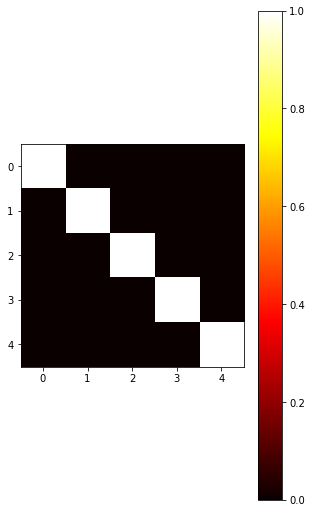

in: 
快马加鞭，指日同圆中国梦
model answer: 
飞龙掣电，临风共舞上海情
desired answer: 
神舟伴月，巡天遥看九州春




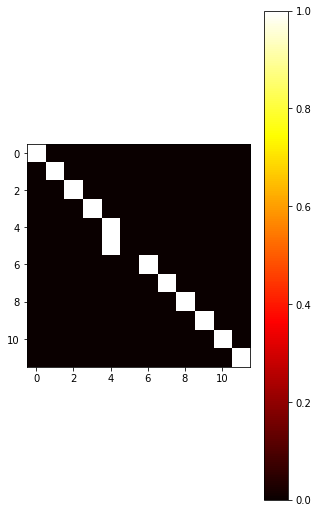

in: 
乔木千章堪借荫
model answer: 
长江万里可撑船
desired answer: 
云山满座好留题




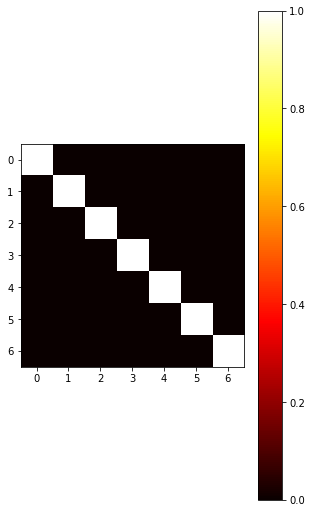

in: 
无风难起浪
model answer: 
有水不流云
desired answer: 
有路怕塞车




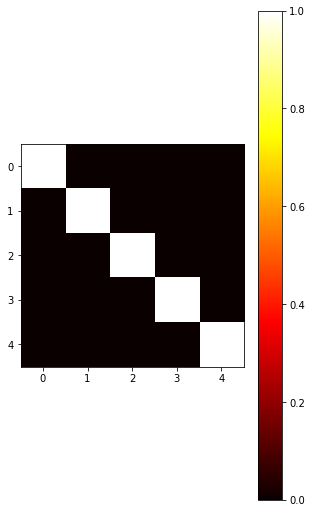

in: 
笔落三江摇五岳
model answer: 
诗吟九曲唱千秋
desired answer: 
墨扬四海荡九州




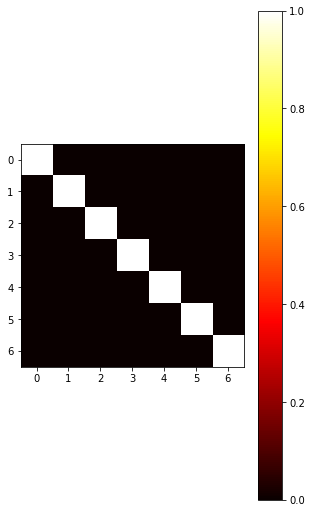

in: 
东风送暖千家乐
model answer: 
春雨浇花万户春
desired answer: 
旭日融合万户春




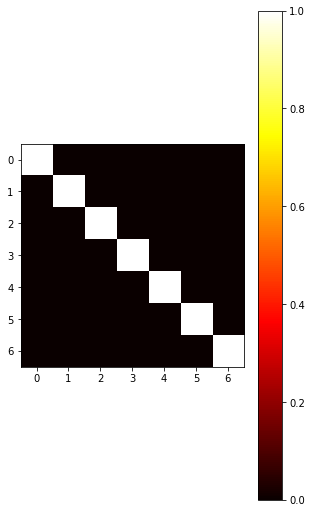

in: 
好花偏遇三更雨
model answer: 
明月难遮一夜情
desired answer: 
破屋又遭连夜风




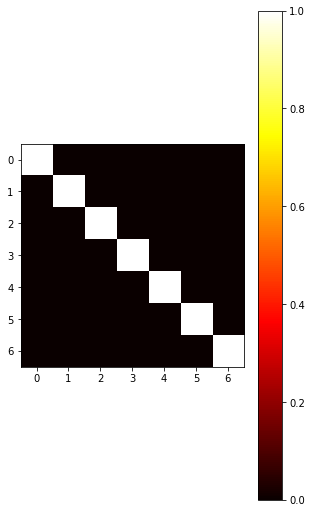

in: 
山色好从高处赏
model answer: 
春光可与远朋游
desired answer: 
钟声远自雨中听




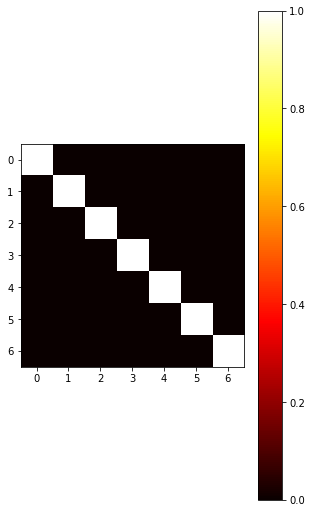

in: 
蛟龙入海惊天地
model answer: 
玉兔登台贺太平
desired answer: 
玉兔飞空震宇寰




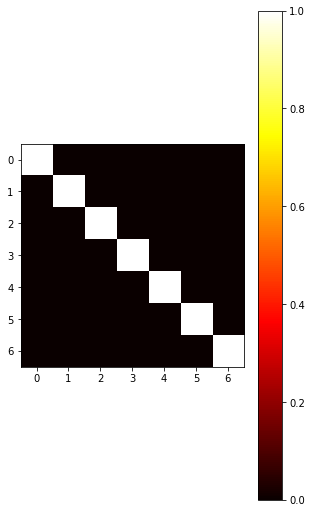

in: 
燕子邀春同上路
model answer: 
桃花带雨共开心
desired answer: 
梅花伴雪共还家




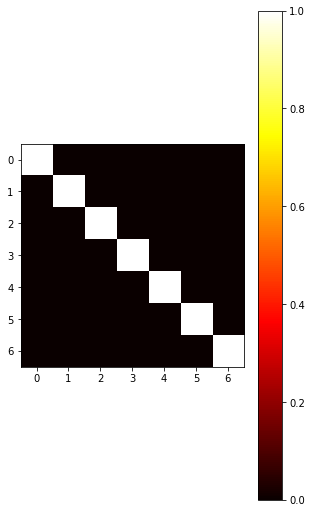

in: 
屋瓦瓦瓦屋
model answer: 
水扁扁扁水
desired answer: 
牛奶奶奶牛




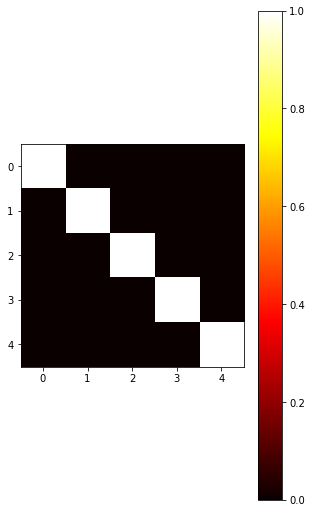

in: 
事忆当年无对错
model answer: 
情牵故国有情缘
desired answer: 
而今一别不相思




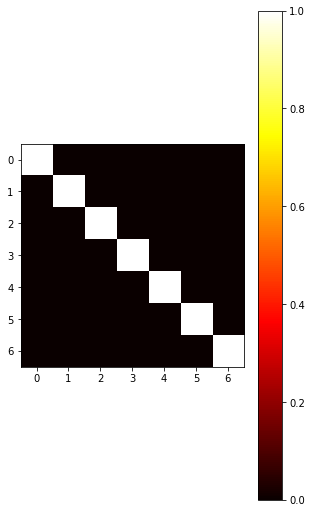

in: 
身披霞彩沐馨风，都来此地
model answer: 
手握春光辉碧宇，不负斯天
desired answer: 
人步花丛寻野趣，乐在其中




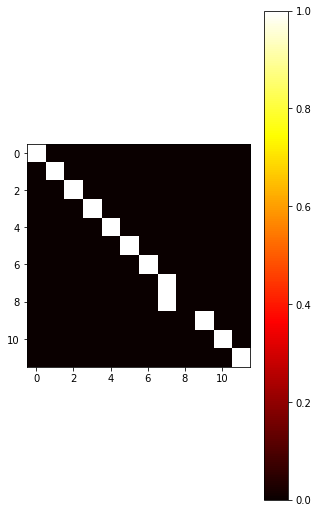

in: 
好色贪官频落马
model answer: 
痴情傻子总吃香
desired answer: 
多情少妇爱牵牛




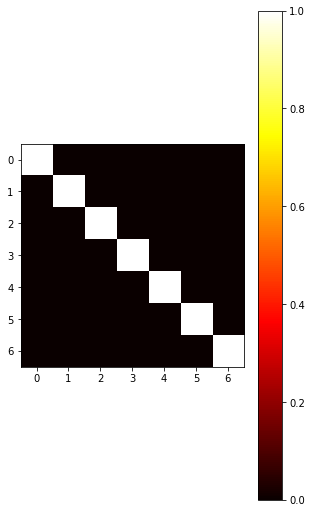

in: 
榛棘
model answer: 
梧桐
desired answer: 
蓬蒿




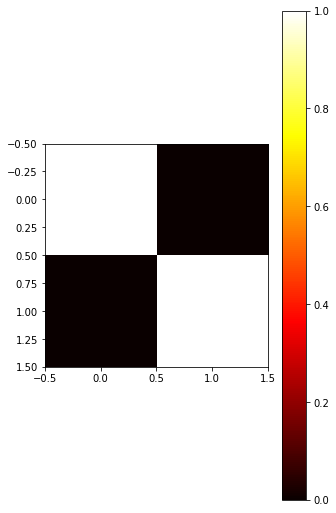

in: 
千年粤北瑶山绿
model answer: 
万里春秋华夏红
desired answer: 
万仞云中天井红




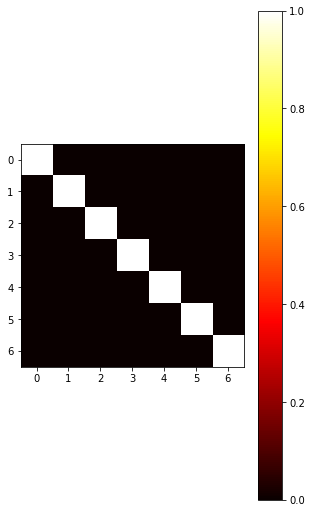

in: 
新潮激起千层浪
model answer: 
骏马嘶飞万里春
desired answer: 
大海奔来万里涛




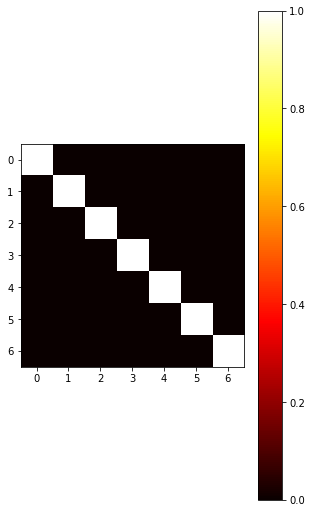

in: 
太空漫步，神州九万里灰霾，奔来眼底
model answer: 
大海遨游，华夏五千年历史，涌上心头
desired answer: 
寰宇聚焦，极地千平方臭氧，惊醒议程




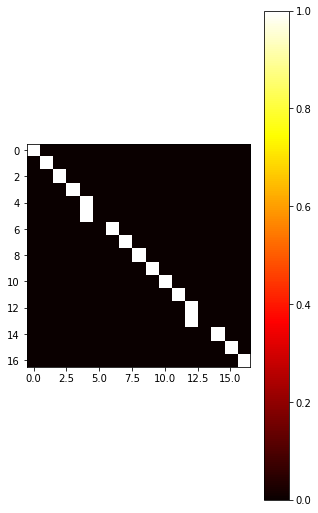

in: 
朔气传金柝
model answer: 
春风飨柳梅
desired answer: 
秋风送黑鸿




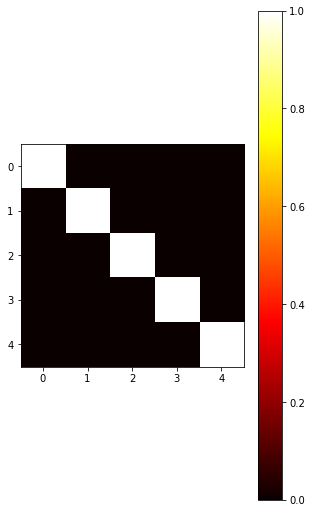

in: 
樵歌远去山犹静
model answer: 
牧曲悠扬水自悠
desired answer: 
岸柳低垂水自流




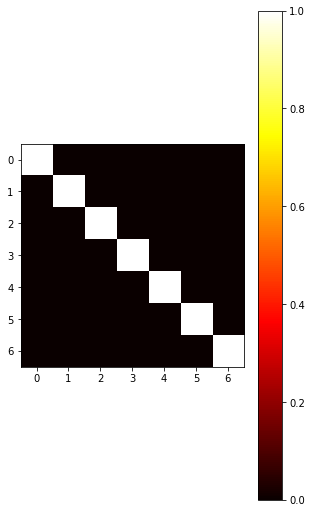

in: 
晚岁凌霜知竹节
model answer: 
春风得意吻金沙
desired answer: 
报春傲雪显梅香




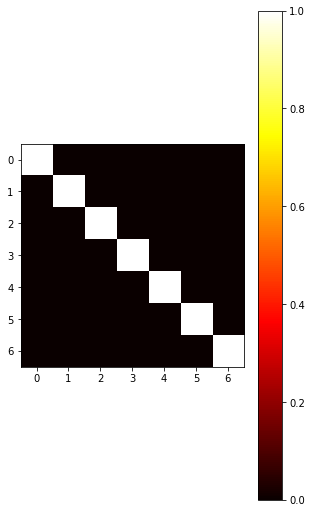

in: 
皆兄皆弟，人为子牛贺
model answer: 
同心同德，家治国家兴
desired answer: 
乐道乐天，谁云原宪贫




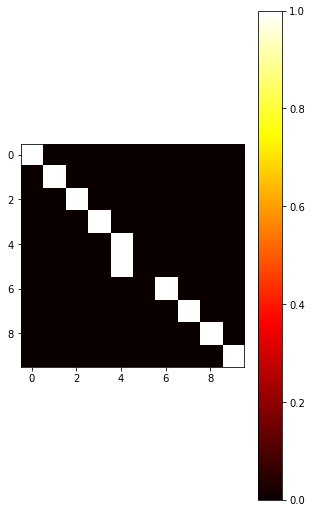

in: 
人不做官马加爵
model answer: 
子遵将道牛作狼
desired answer: 
白找靠山福太沉




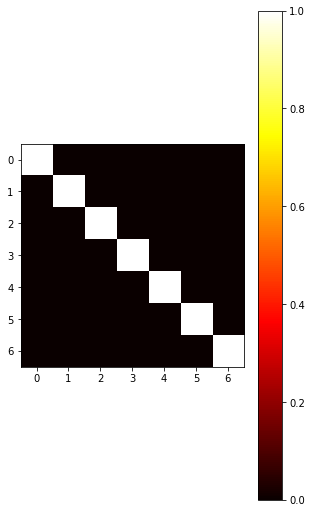

in: 
上学
model answer: 
中和
desired answer: 
西医




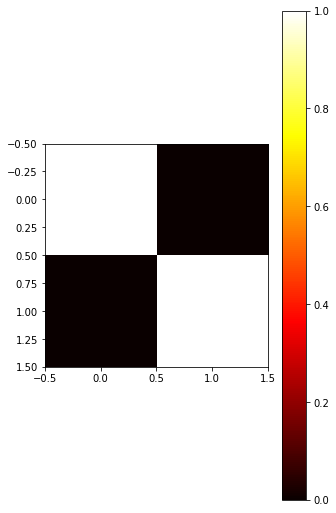

in: 
中秋夜话，问人生可否圆梦
model answer: 
大地春天，看我我不能放心
desired answer: 
世事苍茫，唯道德乐乎上心




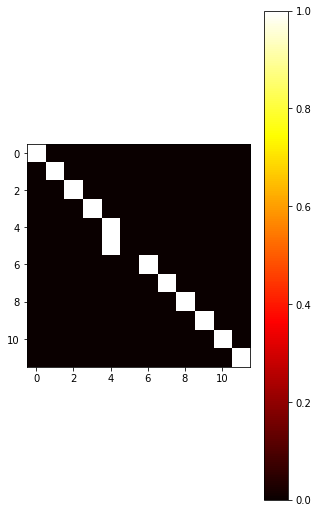

in: 
一纸春诗梅作序
model answer: 
满庭秋色月为媒
desired answer: 
两束艳朵骨存心




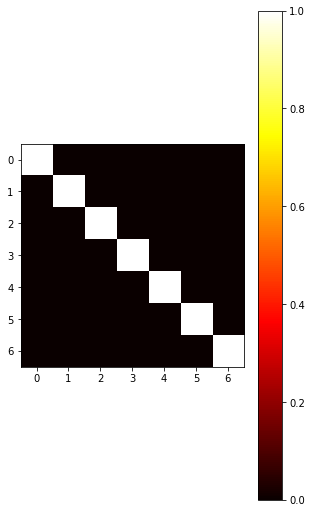

in: 
天生险隘，奇峰要寨，历代兵家频据此
model answer: 
地道苍茫，大道无疆，千秋道路正宜人
desired answer: 
地显风光，胜迹名园，今朝雅客竞游斯




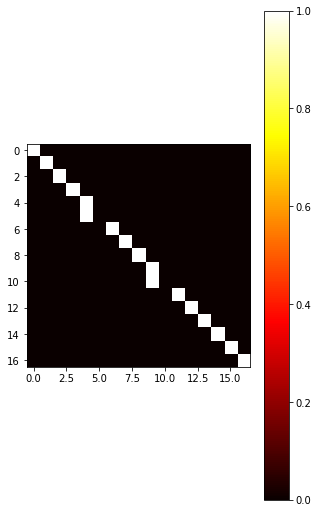

in: 
仙阁凌九霄，眺秦光汉月臻云锦
model answer: 
龙潭腾千里，听海浪长风破浪潮
desired answer: 
春水弹三曲，听龙首凤城唱大风




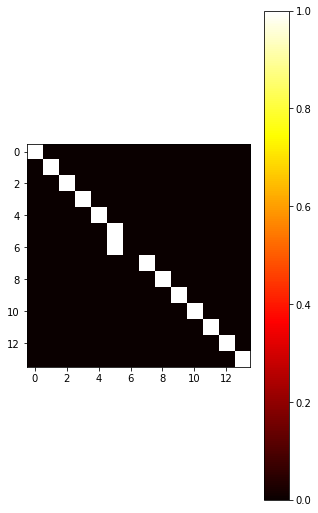

in: 
灯下吟诗人自雅
model answer: 
案头泼墨韵尤浓
desired answer: 
山中吃肉虎真凶




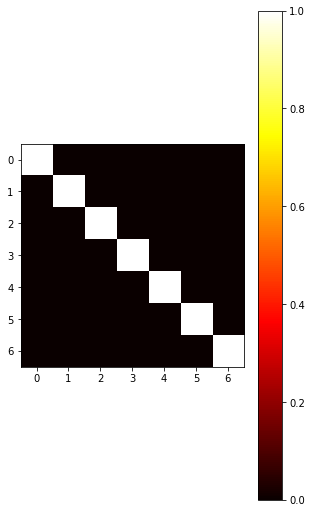

in: 
出海眼无冬无夏
model answer: 
入门心有我有谁
desired answer: 
泛波心有温有凉




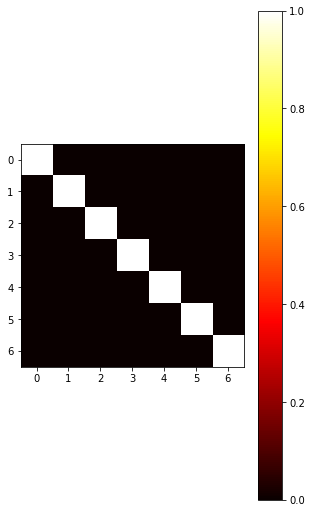

in: 
瞻仰罗衣殿堂，堪称胜地蓬莱，翠柏森森云海无际
model answer: 
仰观鹿洞观景，恰似兰亭庾岭，鸾凤恰恰凤池齐飞
desired answer: 
追思秀才生世，谨守人间正道，鹏程渺渺众口有碑




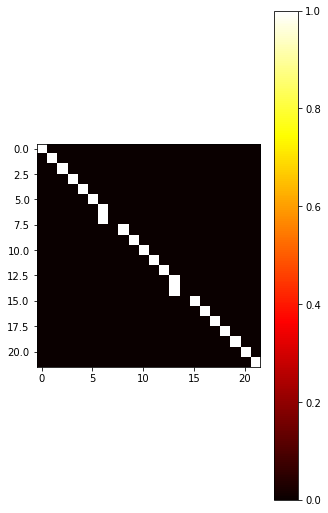

in: 
宝幢
model answer: 
莲花
desired answer: 
莲花




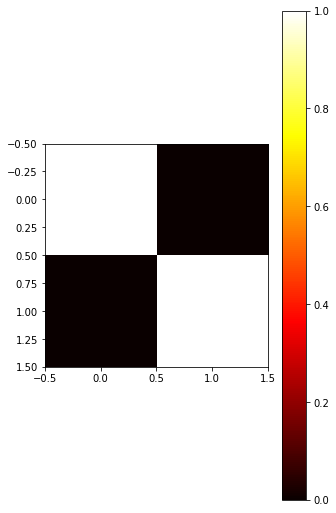

in: 
妙手胜神工，长路纵横，织成村落小康网
model answer: 
春风催骏业，大江浪涌，展就家居新纪元
desired answer: 
真情齐浩宇，朝阳喷薄，盖上交通大业章




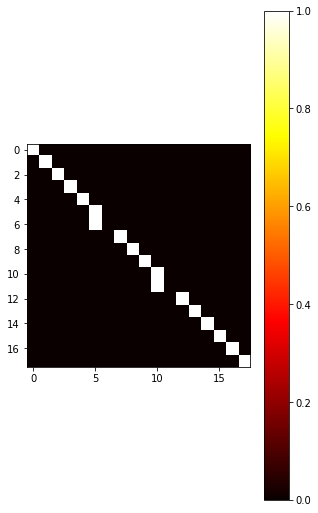

in: 
骑楼占地停单骑
model answer: 
破壁题云接九破
desired answer: 
当铺融资图便当




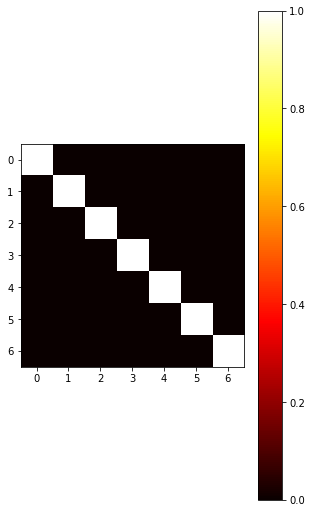

in: 
花底一弦长恨调
model answer: 
月中半夜惹愁愁
desired answer: 
月间半盏浅愁诗




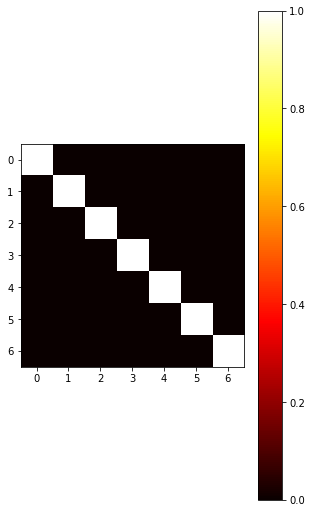

in: 
狂心未灭诗风老
model answer: 
醉意重开画意浓
desired answer: 
铁骨难销胆气豪




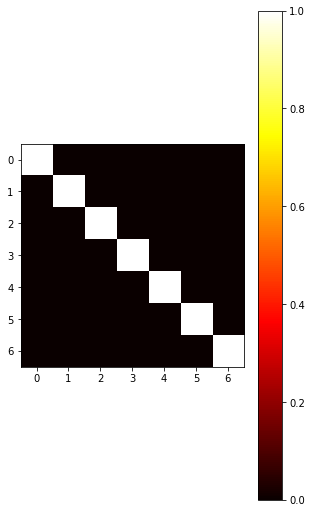

in: 
循声救苦，洒露消灾，法雨济苍生，南海非遥呈宝相
model answer: 
迦叶成禅，慈航济世，慈航通海岳，佛门无处有慈航
desired answer: 
诚者则灵，求之必应，佛光辉大地，西天宛在见慈心




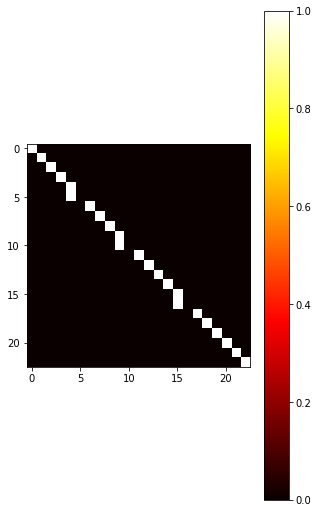

in: 
云移竹影临门翠
model answer: 
雨润荷香入室香
desired answer: 
日照花香满地红




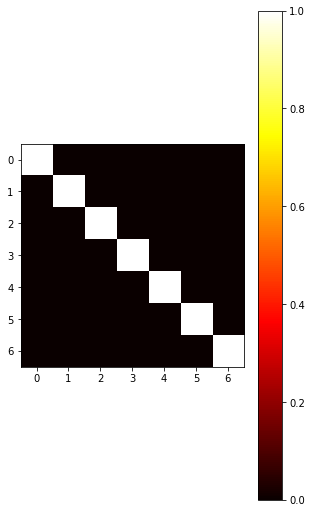

in: 
弹铗而歌争待遇
model answer: 
挥戟以卧自成全
desired answer: 
沏壶好茗赛神仙




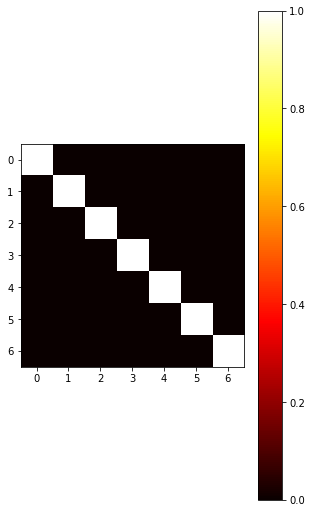

in: 
三农为首，神州壮丽金瓯固
model answer: 
万众同心，大地欢腾国运昌
desired answer: 
九亿当先，民族繁荣玉宇开




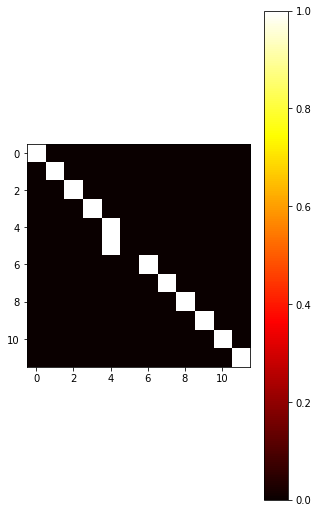

in: 
生日辉煌，听五洲儿女，同声祝福声声切
model answer: 
迎春灿烂，看一路凯歌，一路飞歌路路高
desired answer: 
蓝图宏伟，看各族人民，齐步向前步步高




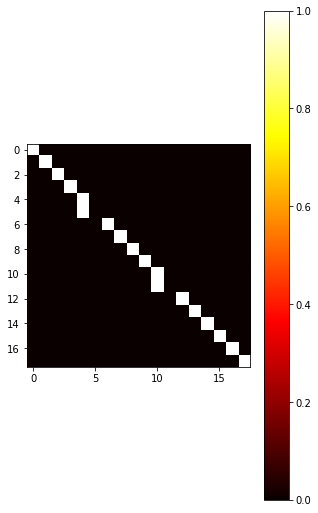

in: 
芳草白云留我住
model answer: 
清风明月任君行
desired answer: 
秋风明月度江来




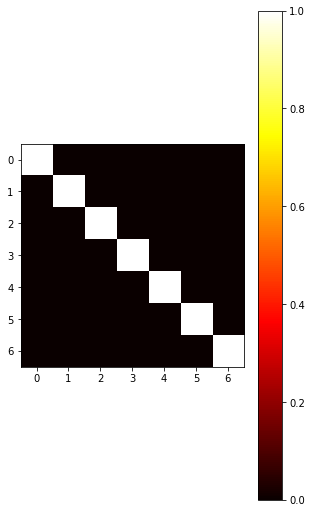

in: 
百病千疾都治愈
model answer: 
五湖四海共同源
desired answer: 
一轮三次尽消除




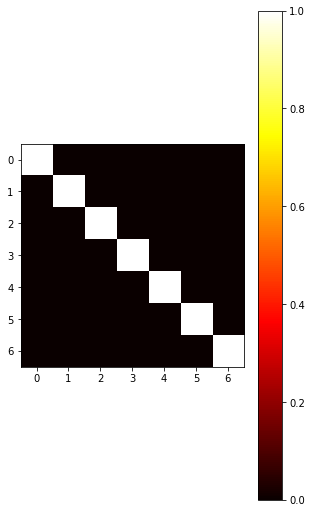

in: 
一梦浮生皆过往
model answer: 
千年历史是前缘
desired answer: 
几怀清月尽沧桑




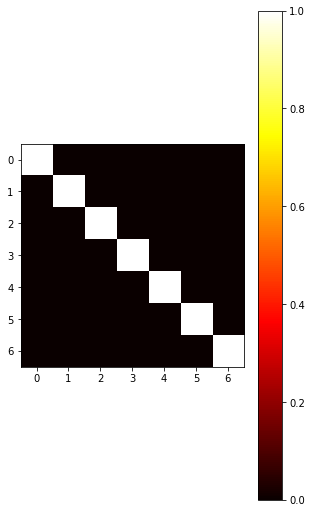

in: 
冷月空明秋雨静
model answer: 
寒潭冷暖晚风寒
desired answer: 
飞云黯淡夕阳闲




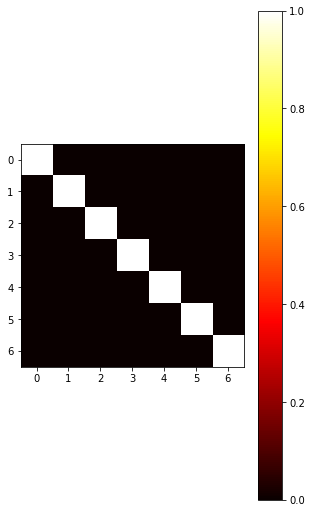

in: 
风剪琼枝滴碎玉
model answer: 
雨敲石径挂流泉
desired answer: 
燕穿柳缕乱金丝




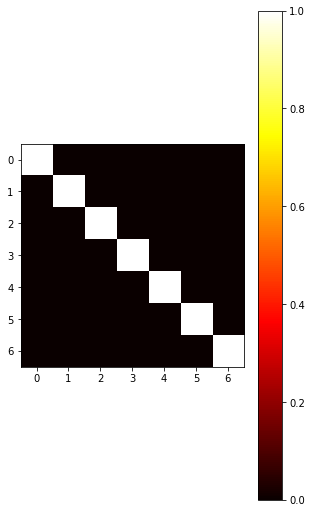

in: 
已彻骨深寒，倩影依稀，有我空庭长饮月
model answer: 
将留心寂寞，清风悠远，无人羁客不羁人
desired answer: 
还伤情正浓，珠泪难拂，无君绣帘尽卷风




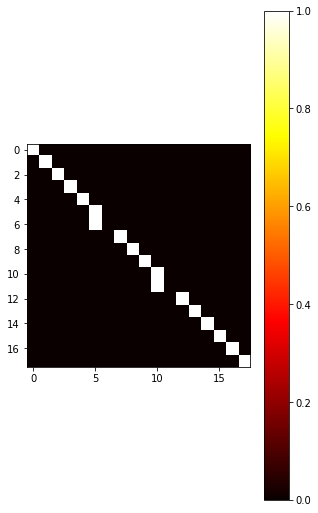

in: 
虎振雄风，小康同步青云路
model answer: 
龙腾盛世，华夏共迎赤子心
desired answer: 
兔生瑞气，大有齐描盛世图




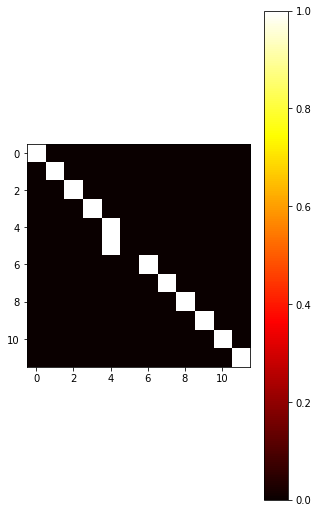

in: 
心死人无语
model answer: 
梦回泪有痕
desired answer: 
花凋叶自卑




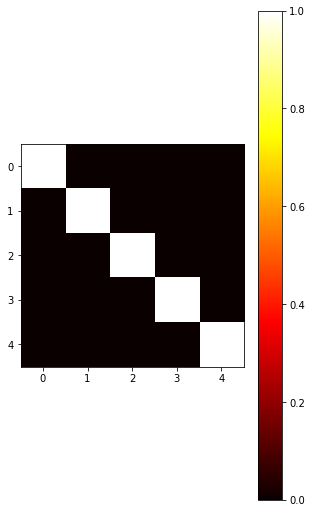

in: 
堪自在簪星，梦想飞扬通大道
model answer: 
不糊涂糊糊，文明矩矩步虚空
desired answer: 
纵荒唐论剑，狂心未歇赌风流




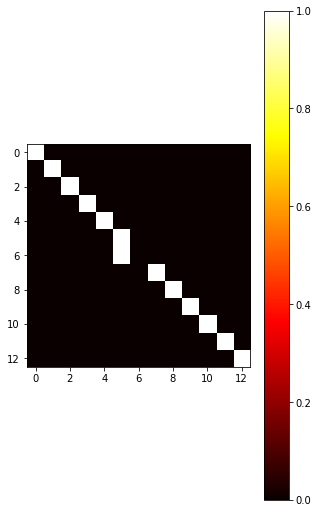

in: 
悬河风起黄天荡
model answer: 
抗日虎临赤子行
desired answer: 
大海浪回界山关




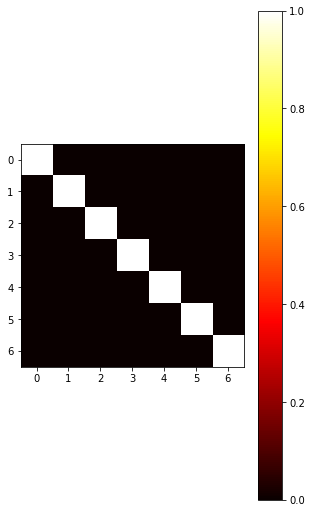

in: 
人不做官马加爵
model answer: 
子遵将道牛作狼
desired answer: 
白找靠山福太沉




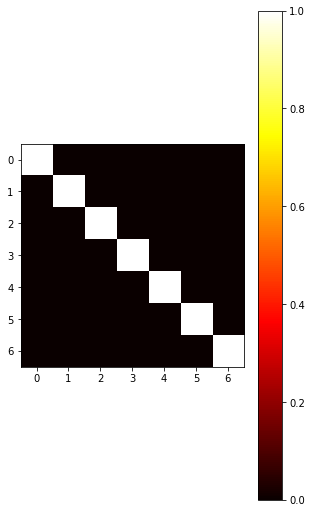

in: 
当阳城高楼映月，园林滴翠，陶朱兴旺，生财敛福
model answer: 
迎奥运快马迎春，户户呈祥，金蟒祥和，发展迎春
desired answer: 
沮漳地玉树临风，稻海泛金，花果丰登，引领飞歌




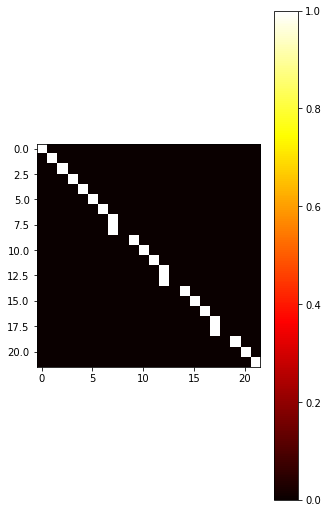

in: 
晓雾
model answer: 
朝霞
desired answer: 
尘氛




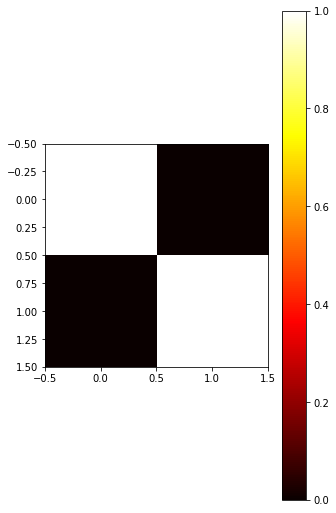

in: 
历尽严冬寒
model answer: 
斟来细雨春
desired answer: 
更知初春暖




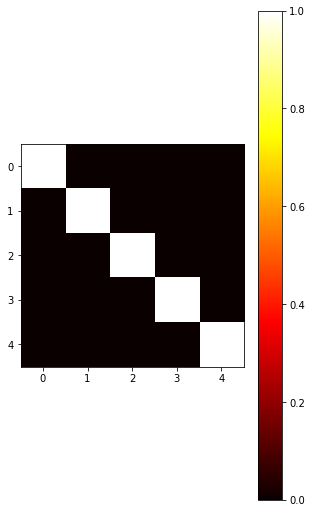

in: 
多彩田园谁绘出
model answer: 
大家大地我编排
desired answer: 
无穷景色网传来




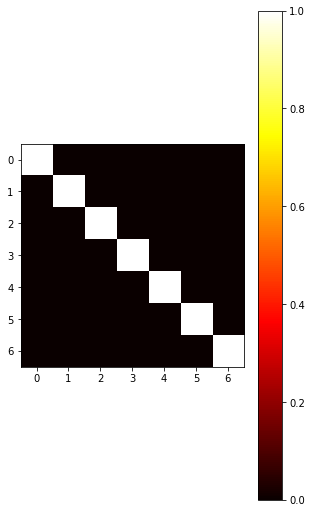

in: 
飞泻出壶觞，直欲挟天阙仙云，激鸣九曲
model answer: 
高吟吟柱石，且看破石林砥柱，啸傲千秋
desired answer: 
薄游观起落，好重觅匡庐奇想，镌刻孤亭




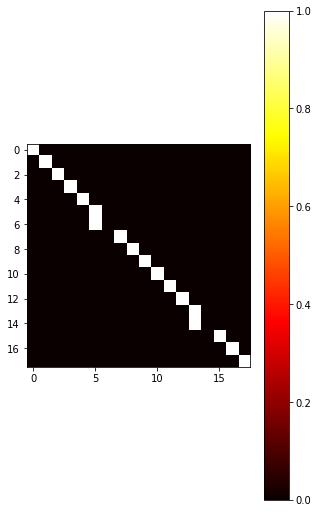

in: 
春水曾经寒士院
model answer: 
秋风又是故人家
desired answer: 
落花偏到妙僧头




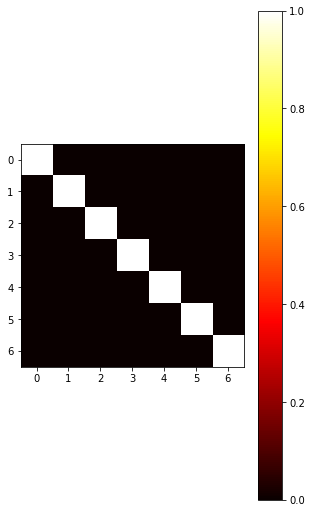

in: 
愁寻曲道士
model answer: 
怕听讼将军
desired answer: 
热借竹夫人




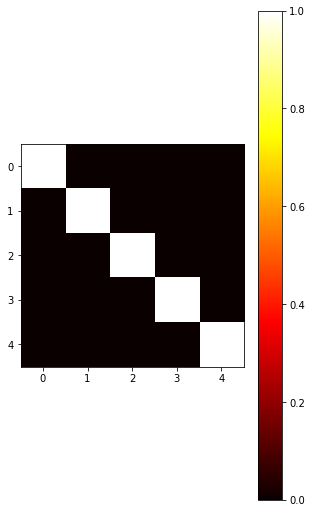

in: 
古径幽山，听几只黄莺唱晚
model answer: 
晚霞夕照，看一帘明月当时
desired answer: 
晴空渺际，望一双白鹭迎阳




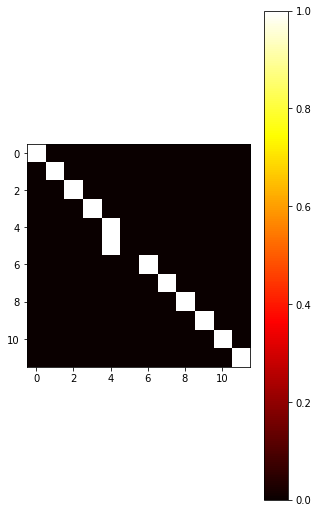

in: 
越岭涉江，求索人生无注脚
model answer: 
天山造化，造福社会有机心
desired answer: 
问天顿地，忠贞岁月有骚文




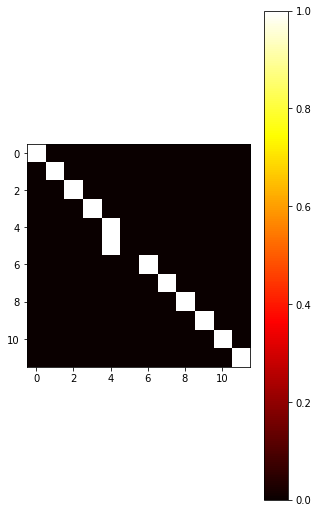

in: 
金融海啸金生水
model answer: 
玉砌虹飞玉迸珠
desired answer: 
裙带关联裙下风




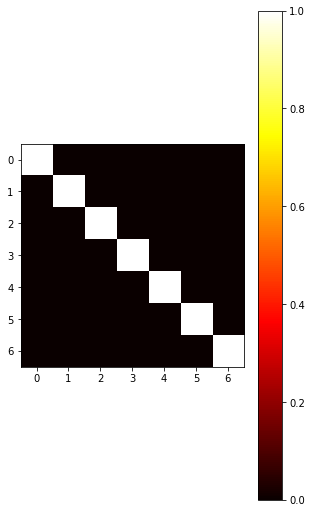

in: 
满座春风传乐事
model answer: 
一轮明月寄闲情
desired answer: 
一盘饺子郁亲情




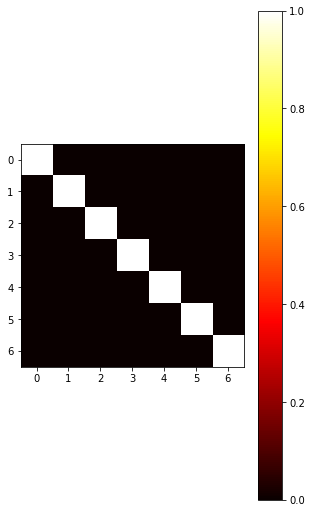

in: 
笔架山梁云砚墨
model answer: 
文抄卦卷性情真
desired answer: 
毫濯海腹宇纸笺




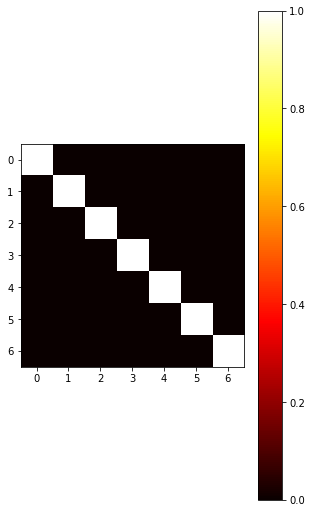

in: 
夜袭珍珠港
model answer: 
朝迎鲁客厅
desired answer: 
天成龙凤胎




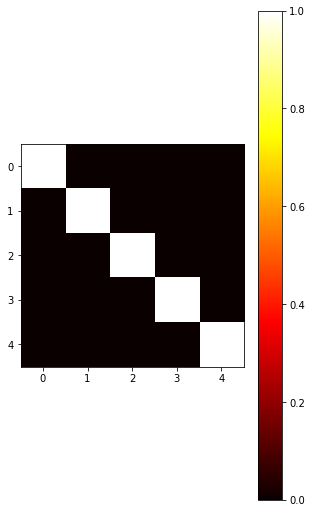

in: 
要见雌雄真对手
model answer: 
须知大匠大钻头
desired answer: 
常争黑白老交情




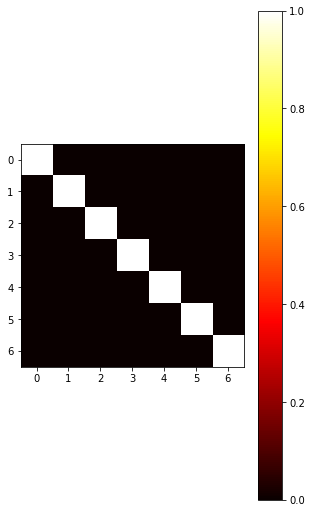

in: 
只盼来年，春醒桃红柳绿
model answer: 
常观此日，花开果满山红
desired answer: 
且迎破晓，云开月白风清




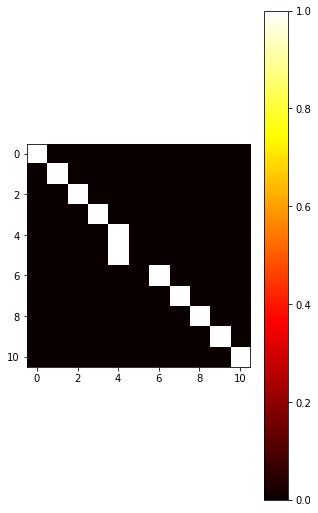

in: 
柳线垂帘云伴月
model answer: 
荷衣带露水连天
desired answer: 
桃花润笔酒浇诗




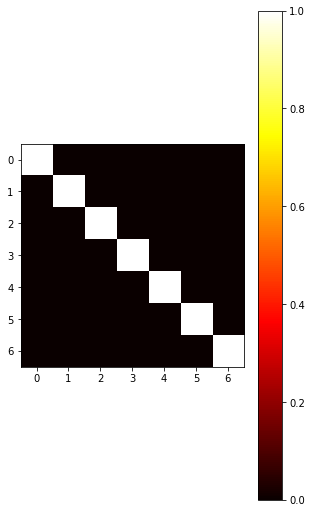

in: 
伤春蕉客卷珠泪
model answer: 
落魄玉人诉爱情
desired answer: 
苦夏闲人烹酽茶




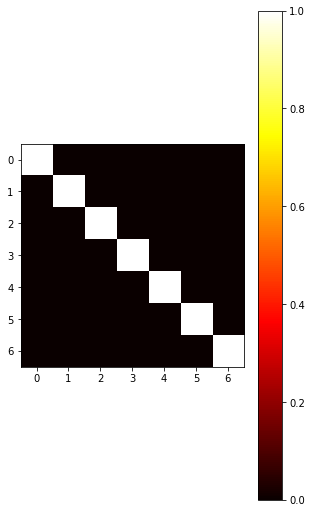

in: 
半杯趣事半杯笑
model answer: 
一卷诗书一卷舒
desired answer: 
一枕清凉一枕风




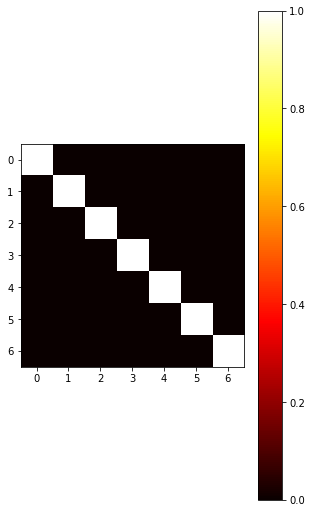

in: 
雨树青山界面谱
model answer: 
风花翠柳池塘春
desired answer: 
春花秋月换诗题




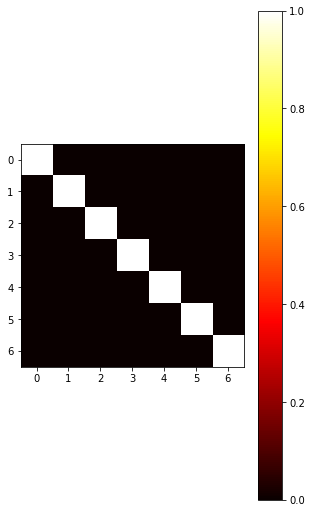

in: 
飞花几笔春心事
model answer: 
落叶一笺秋意诗
desired answer: 
大雪漫天梅精神




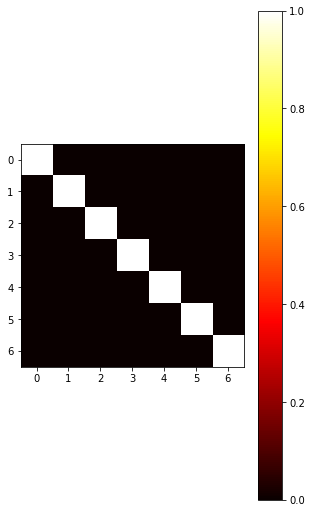

in: 
无气无烟无味无声，低碳行、行通低碳道
model answer: 
有心有梦有形有意，清风朗、朗朗清风人
desired answer: 
省钱省事省心省力，老年乐、乐煞老年人




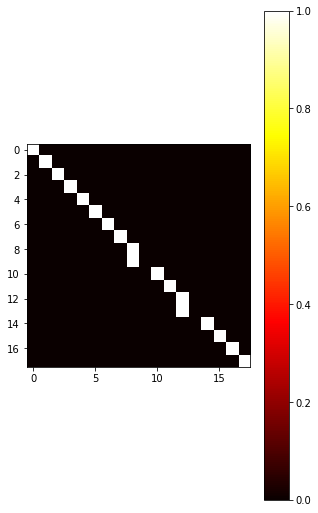

in: 
辽阔海天，月满神州辉两岸
model answer: 
平衡生态，风和盛世乐千家
desired answer: 
广袤宇宙，日盈华夏耀全球




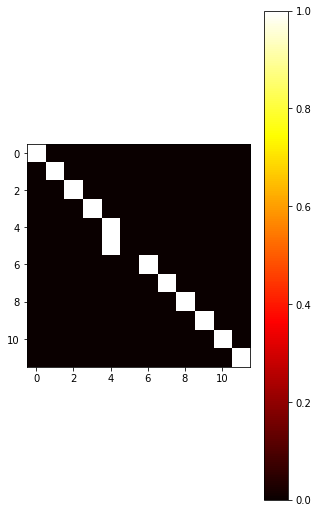

in: 
涯上有泉悬素练
model answer: 
堤前无客醉红尘
desired answer: 
命中无月系红绳




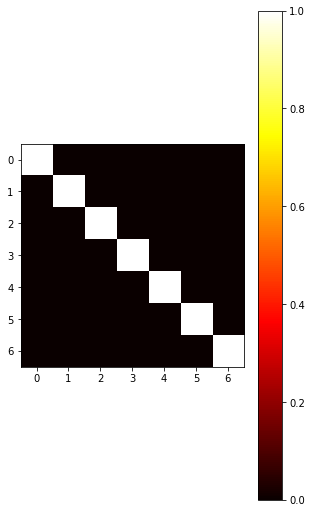

in: 
百感交于无意处
model answer: 
一生不在有缘时
desired answer: 
千情自在不言中




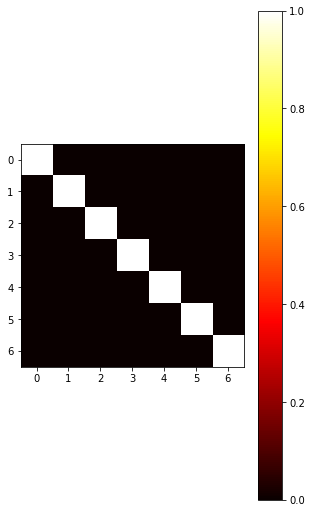

in: 
对天对地对民对国，铸成一座丰碑相报答，捐胆捐肝捐智慧
model answer: 
擎日擎春擎力擎霄，擎起千钧大厦千钧助，兴邦兴业兴山河
desired answer: 
联古联今联水联山，开出千秋锦道共争荣，展诗展画展风光




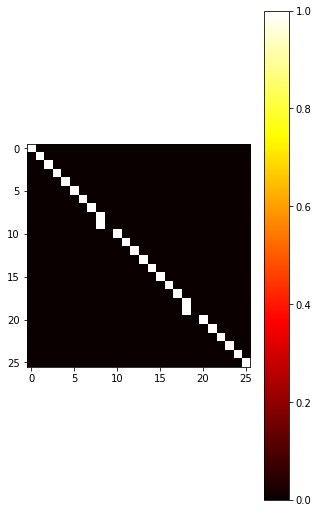

in: 
鸟尽弓藏烹走狗
model answer: 
花生水净送归人
desired answer: 
山穷水瘦恨秋风




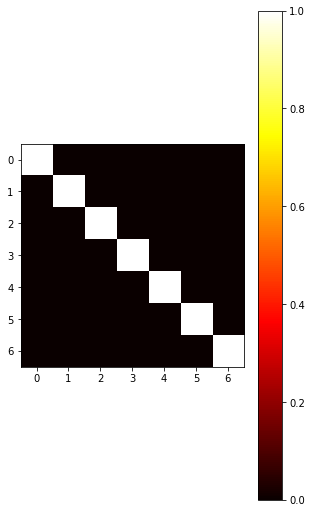

in: 
知春莫过河边柳
model answer: 
爱夏方成塞外梅
desired answer: 
送绿无非槛外风




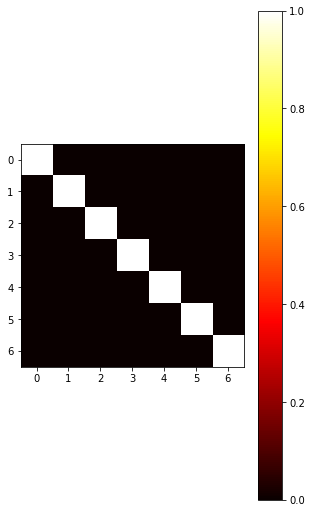

in: 
天地水三官大帝
model answer: 
古今民一帝先皇
desired answer: 
上中下一体同尊




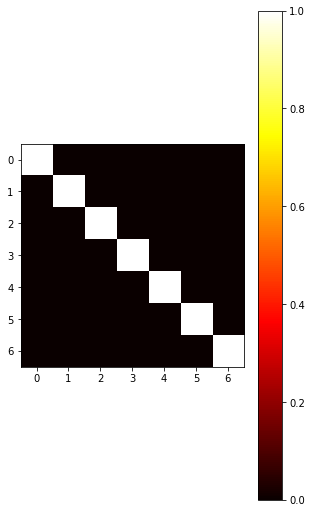

in: 
一庭柳色描春意
model answer: 
满苑梅香醉雪魂
desired answer: 
两岸风光披绿衣




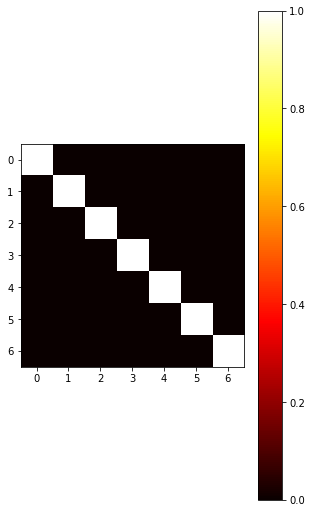

in: 
车间作舞台，演出人生灿烂
model answer: 
柜上开花队，迎接世界和谐
desired answer: 
机器为歌手，讴成曲调悠扬




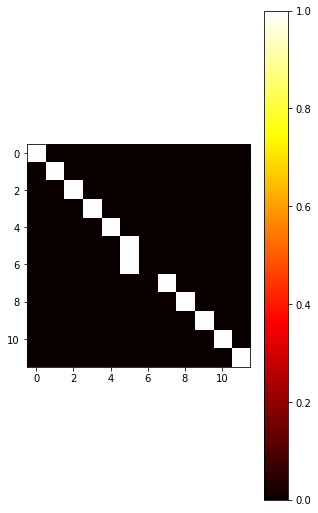

in: 
笔端流畅意
model answer: 
诗里荡生风
desired answer: 
诗尾泻舒心




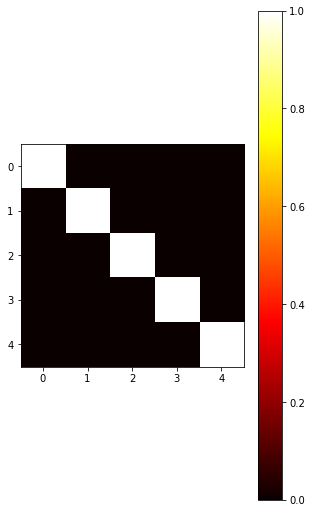

in: 
心有不甘终老去
model answer: 
梦无常怕又重来
desired answer: 
人无遗憾可能吗




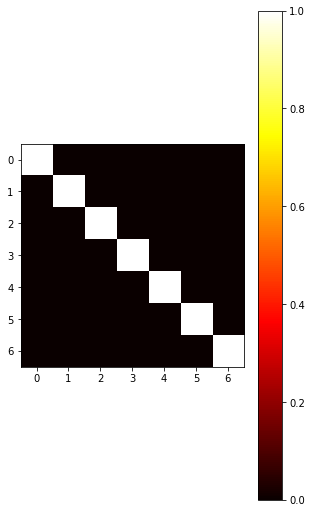

in: 
诗狂未必有佳句
model answer: 
酒醉何妨无醉人
desired answer: 
酒好还须对故人




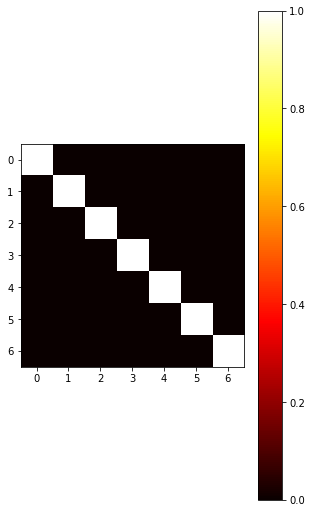

in: 
文澜壮阔，咏吟魏武千年韵
model answer: 
翰墨香浓，书写华章万里春
desired answer: 
古井甘淳，酿造春光十里香




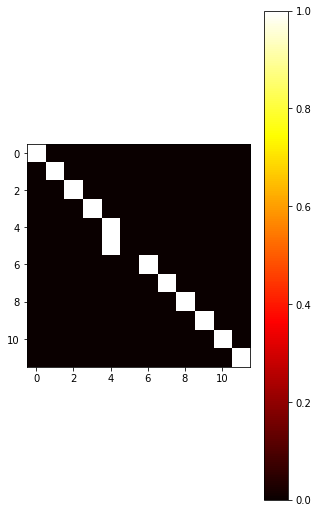

in: 
弹指间我亦为过客，想当年点将兴邦，风云叱咤
model answer: 
扪心处谁不屑心头，看此际飞花飞雪，蓓蕾繁荣
desired answer: 
会心处谁还记劫尘？看此地古碑新宇，山水清佳




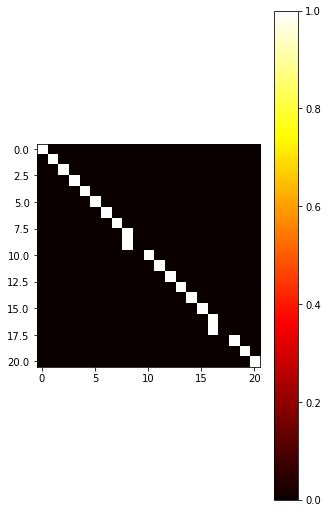

in: 
翻检尘封温旧梦
model answer: 
勾留月影照新妆
desired answer: 
参观日照换新装




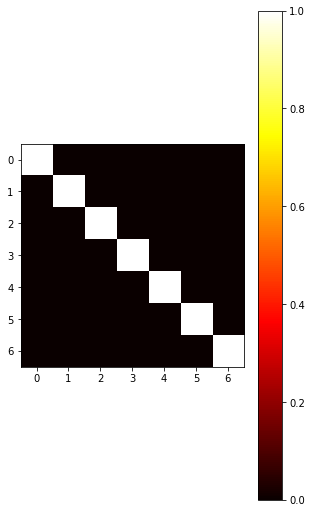

in: 
大泽兴邦，邦威海宇
model answer: 
神光曜日，日曜乾坤
desired answer: 
小龙献瑞，瑞满中华




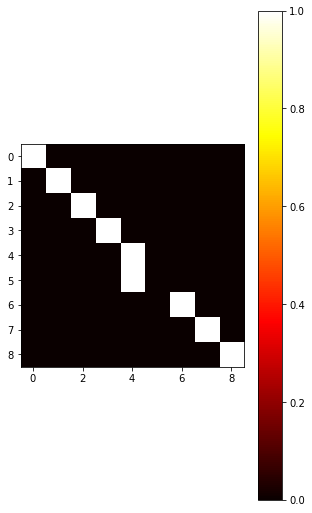

in: 
七秩康强，复职荣休叨舜日
model answer: 
万家幸福，安家乐在乐尧天
desired answer: 
双星朗耀，称觞祝嘏颂尧天




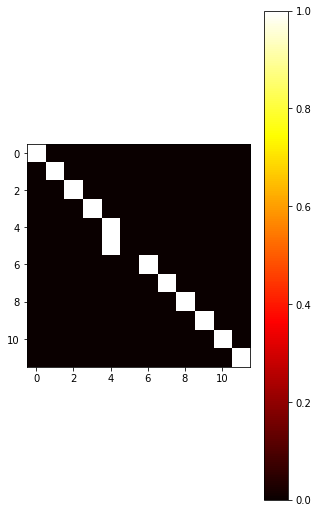

in: 
统筹兼顾兴农业
model answer: 
崛起齐开革命门
desired answer: 
打造提升创品牌




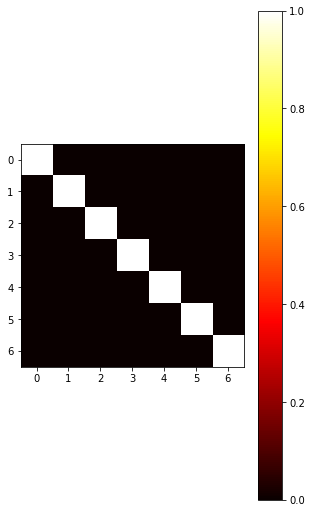

in: 
秋千荡过千山晃
model answer: 
春去来来去树花
desired answer: 
九万一出万两输




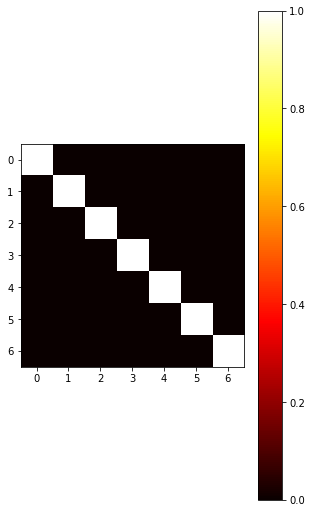

in: 
谁人常住清凉境
model answer: 
我自自观自在天
desired answer: 
那月独于自在天




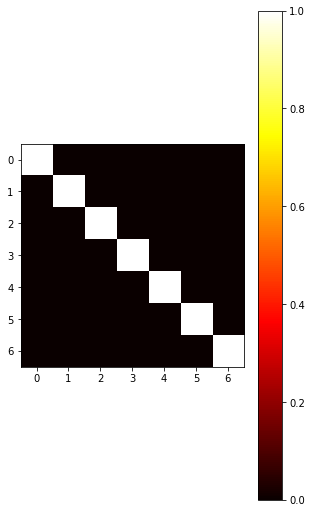

in: 
北渚翔鸥，碧水长天波潋滟
model answer: 
南山耸翠，云山古寺鸟啁啾
desired answer: 
东皋鸣鹤，晴岚嘉树气青葱




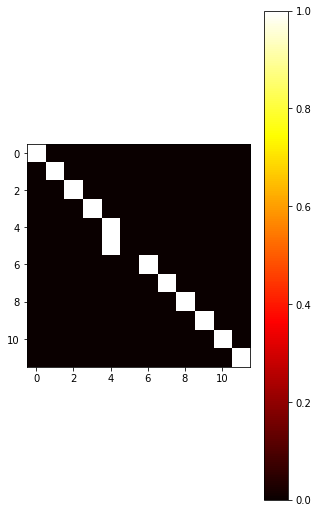

in: 
秋风萧瑟观沧海
model answer: 
明月清辉照古今
desired answer: 
原野繁忙收大田




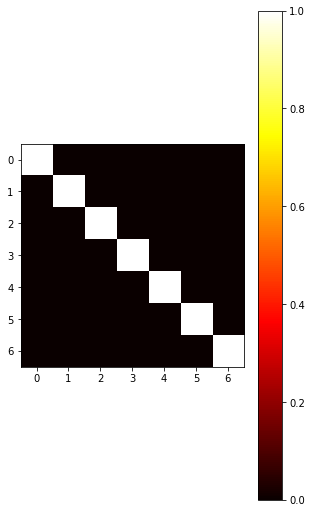

in: 
阶联台斗云霄路
model answer: 
座座座席日月星
desired answer: 
座拥图书道义门




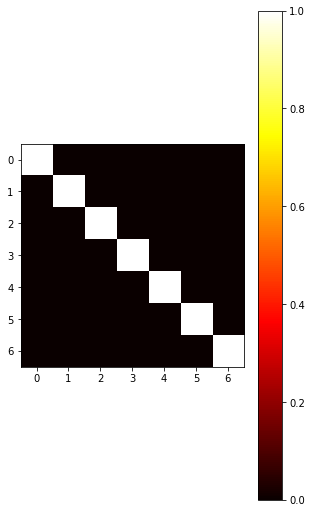

in: 
莺声恰恰春风暖
model answer: 
燕语犹犹秋雨浓
desired answer: 
雾雨蒙蒙景色茫




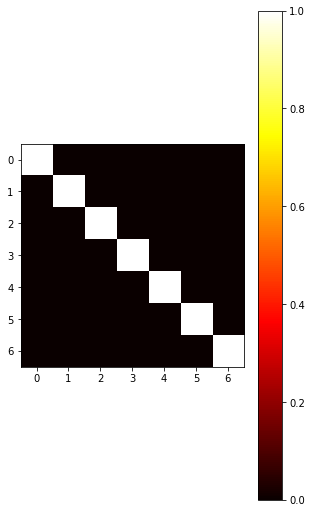

in: 
呼伴而来，快乐釆摘，一篓蓝莓犹带露
model answer: 
农家不老，清风徐拂，千年古韵更怡人
desired answer: 
怡心已醉，温馨拍照，满原美景正摇金




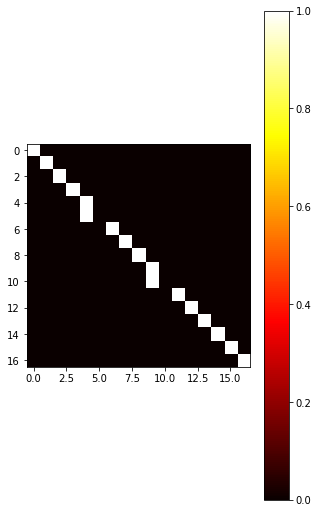

in: 
浩瀚五千年，听龙脊足音，脉动神州，游子梦中朝始祖
model answer: 
矍连三百里，看大河流韵，香飘四海，名伶天下仰先贤
desired answer: 
图腾九万里，传釜山薪火，泽披后世，归根碑下溯源头




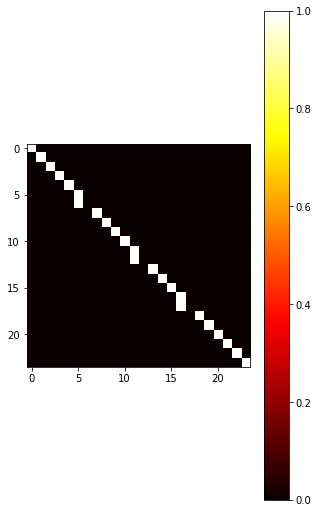

in: 
春花香我梦
model answer: 
秋月照人心
desired answer: 
战鼓壮国威




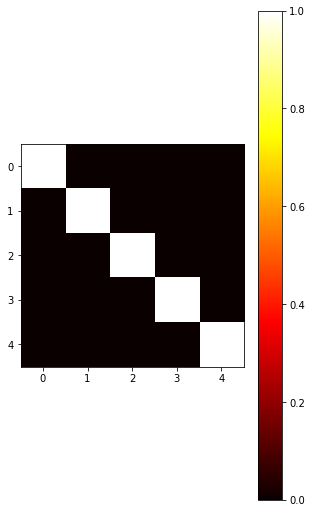

in: 
相对半床书，冀渐臻圣域
model answer: 
独钟千古字，春来度劫元
desired answer: 
但啜一瓯粥，誓不入公门




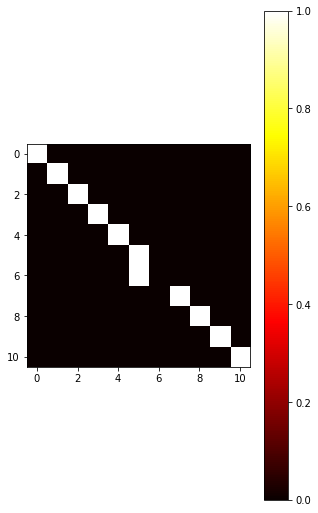

in: 
不欲干鞋沾湿水
model answer: 
但求酒肉话春风
desired answer: 
何妨赤脚濯清流




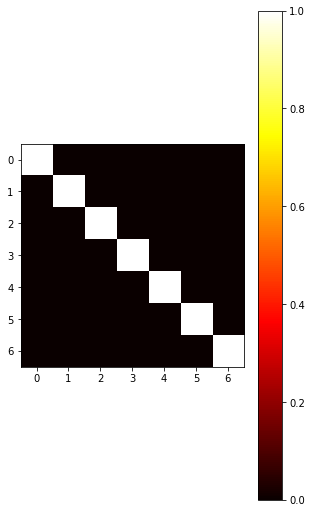

in: 
仁山不老岿先圣
model answer: 
善政无穷耿正恩
desired answer: 
智水长流渥后贤




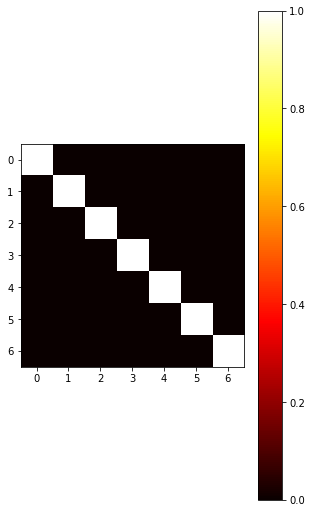

in: 
风声搅乱一帘梦
model answer: 
雨幕遮羞满院春
desired answer: 
霜色压深几丈秋




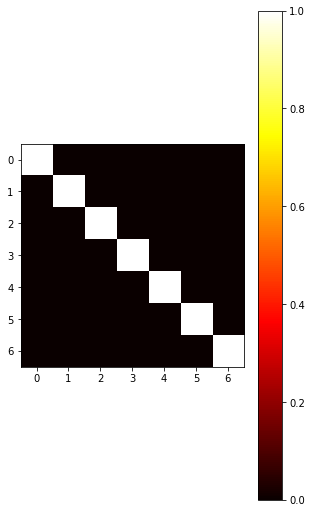

in: 
即烧素菜牛羊猪鸡鸭肉，方便百姓
model answer: 
不舍便官狗棒狗肉鼠狐，鼠到狗头
desired answer: 
又做山珍海味猴头燕窝，供应嘉宾




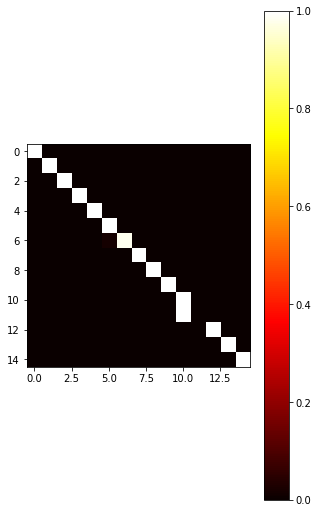

in: 
不止泉明酒
model answer: 
难得月近人
desired answer: 
闲临米老山




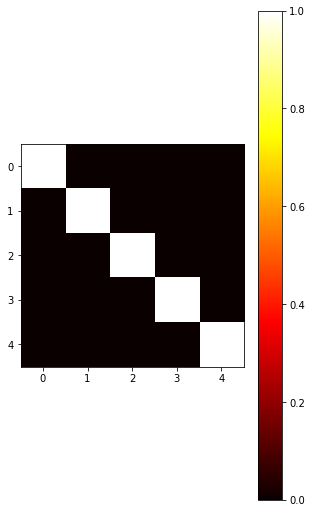

in: 
俎豆古今存圣学
model answer: 
风云天地育英名
desired answer: 
瓣香朝暮愧禅门




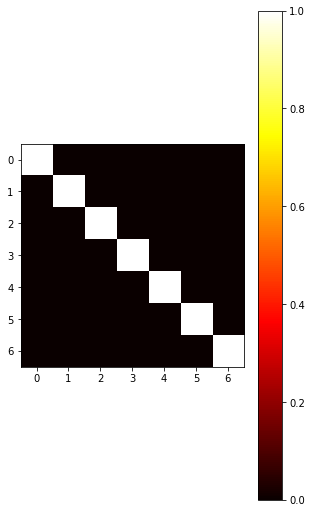

in: 
风织雪被千山盖
model answer: 
雨打窗窗一线连
desired answer: 
柳绣春帘两岸垂




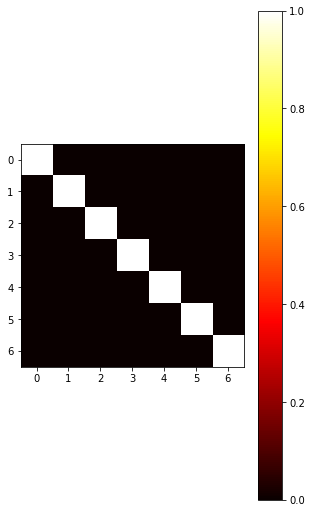

in: 
玉树不哭，挺起脊梁忍住泪
model answer: 
青山难觅，磨穿世界难分情
desired answer: 
国人有志，克服灾难抱成团




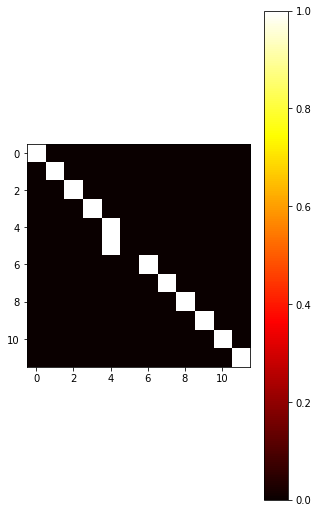

in: 
鉴江植三柏，寓天时地利人和，永昌宗祏
model answer: 
昭圣昭万代，仰祖辈孙绵世德，湄水邵水
desired answer: 
赫奕奠千秋，迁陇水漳川岭海，长溯源头




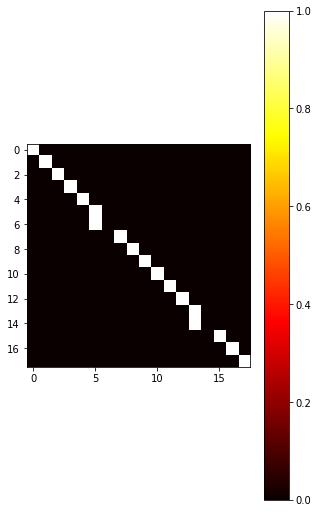

in: 
文博名牌齐荟萃
model answer: 
华夏盛世共辉煌
desired answer: 
昭通产业尽精华




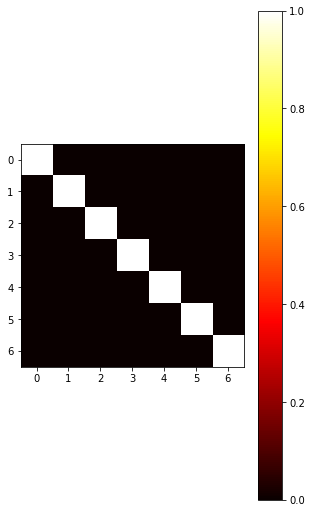

in: 
容成历伶伦律吕，皆有功于后世
model answer: 
使隶韩魏武文韩，擅得道在先生
desired answer: 
隶首数大挠甲子，俱无愧对今朝




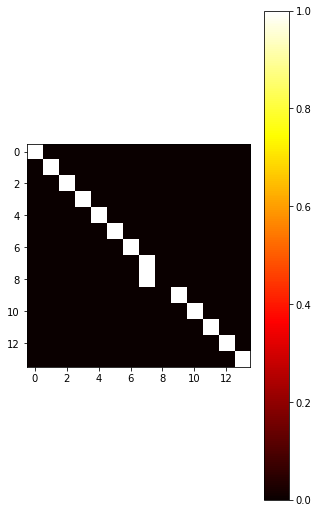

in: 
时有管弦传，十里街衢呈泰象
model answer: 
春无霏雨润，一湖春水润新颜
desired answer: 
恍闻兵马动，千秋风雨入平川




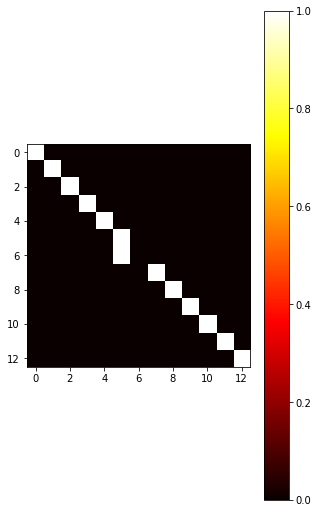

in: 
秋空连碧海
model answer: 
春色染红霞
desired answer: 
昼雨湿青山




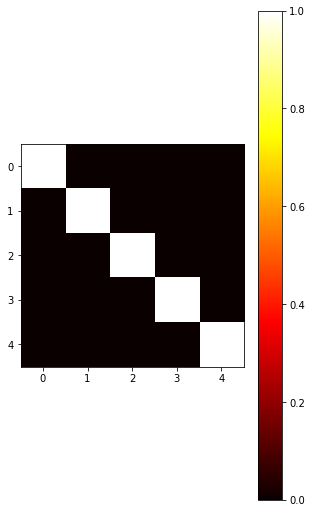

in: 
风雨起南湖，点亮明灯一盏
model answer: 
春光腾北斗，铺开画卷千张
desired answer: 
雪冰封北国，写成绝唱千秋




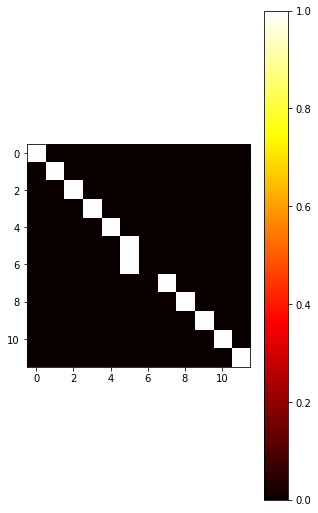

in: 
云出天彩色
model answer: 
月入夜光辉
desired answer: 
月满斗魁明




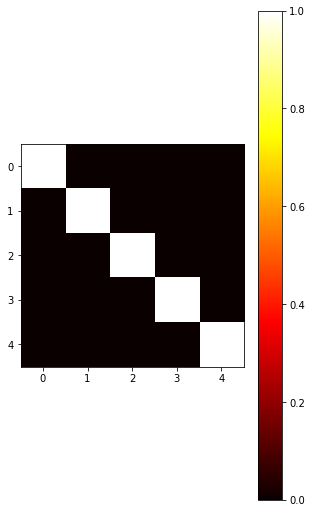

in: 
落叶归根恋故土
model answer: 
飞花逝水盼新春
desired answer: 
悲秋无语吊斯人




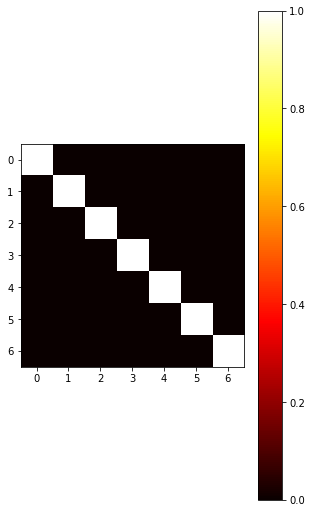

in: 
快步前途勤拍马
model answer: 
灵犀大地勇拼牛
desired answer: 
畅谈往事爱吹牛




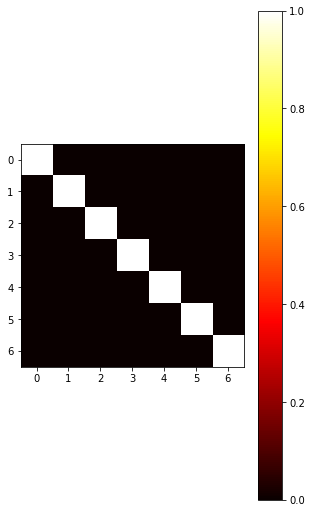

in: 
桥通路畅小康景
model answer: 
日丽风和盛世春
desired answer: 
水碧天蓝重庆城




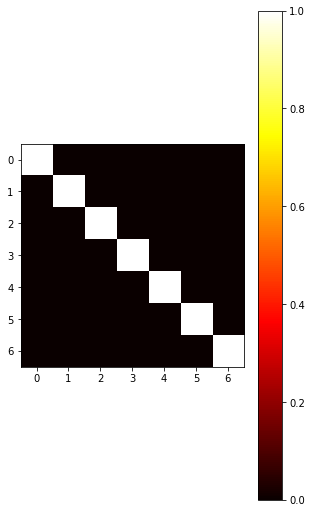

in: 
风卷松声过太行，华岳撑霄留千程险峻
model answer: 
雪消酷暑避寒舍，青山买卖有一片殷勤
desired answer: 
云从青野连汾水，黄河入海牵九曲苍茫




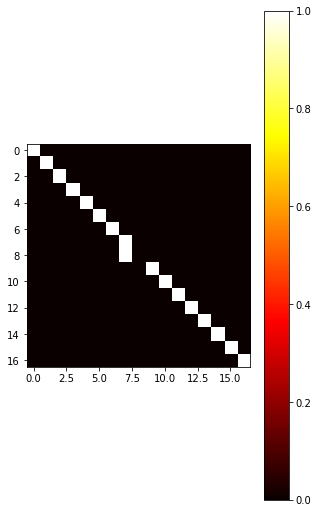

in: 
情怀暗老诗心淡
model answer: 
笔墨清新画意浓
desired answer: 
尘梦已轻禅意深




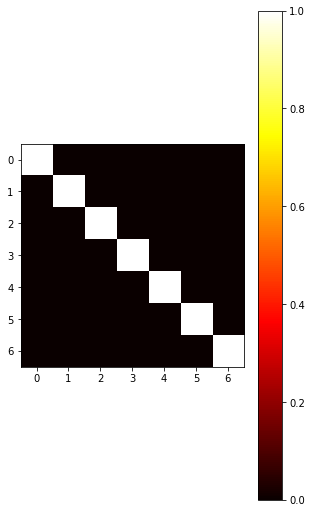

in: 
红无百日，独有心花开四季
model answer: 
春到千山，但凭爱意化千秋
desired answer: 
墨守成规，但凭往事越千年




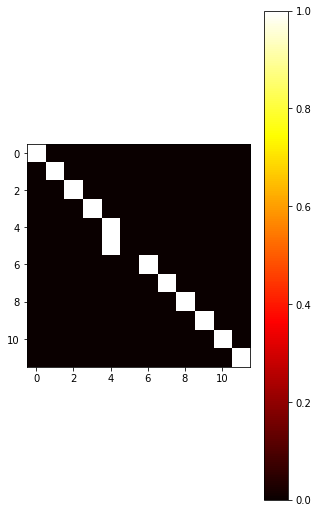

in: 
晓雾
model answer: 
朝霞
desired answer: 
尘氛




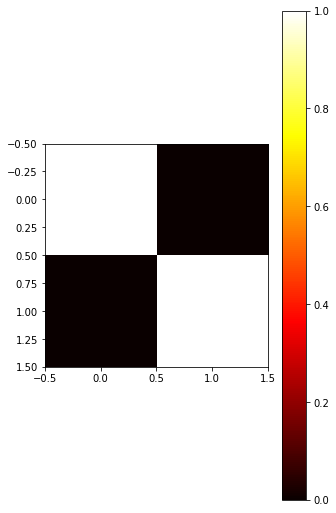

in: 
挥毫始觉学识浅
model answer: 
举笔方知翰墨香
desired answer: 
温古才知笔墨香




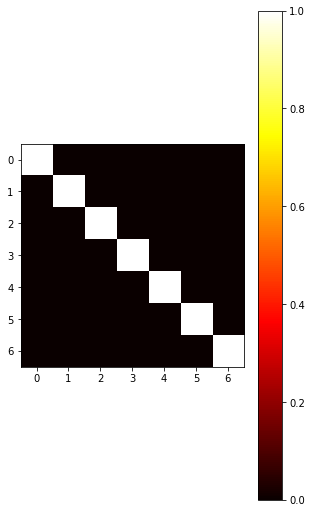

in: 
目光所及皆佳画
model answer: 
心事如何不认真
desired answer: 
鬼斧神工本自然




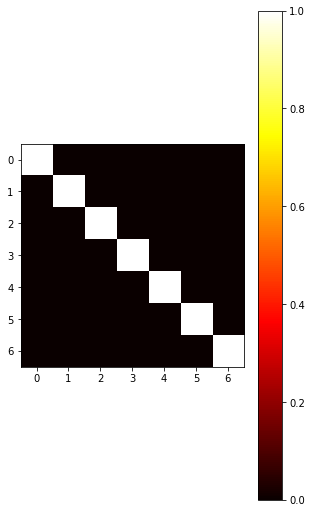

in: 
风正民心顺
model answer: 
政廉政策明
desired answer: 
人和国日安




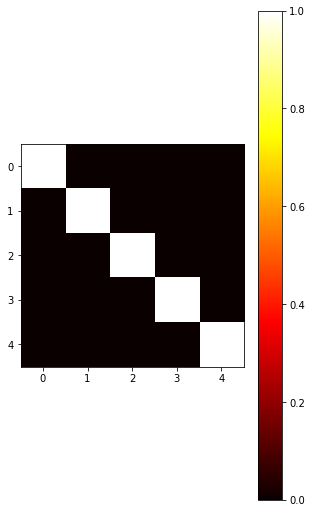

in: 
草舍书香留雅客
model answer: 
竹篱瘦影上青天
desired answer: 
兰亭竹韵驻清怀




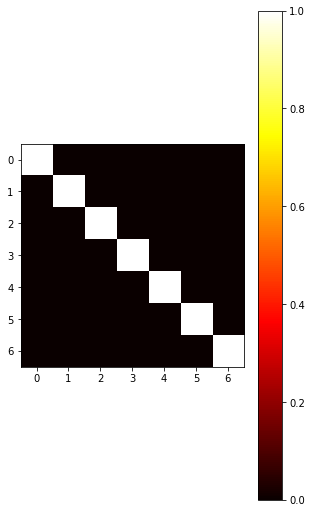

in: 
清风万亩冲凉去
model answer: 
明月一轮照古来
desired answer: 
淡酒一壶避暑来




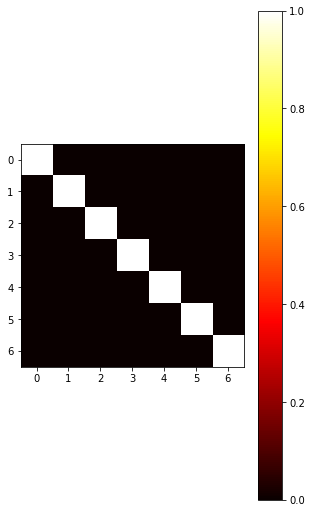

in: 
花香鸟语，浩荡暖风拂大地
model answer: 
鸟语花香，辉煌盛世耀神州
desired answer: 
景美人和，文明春雨润妫川




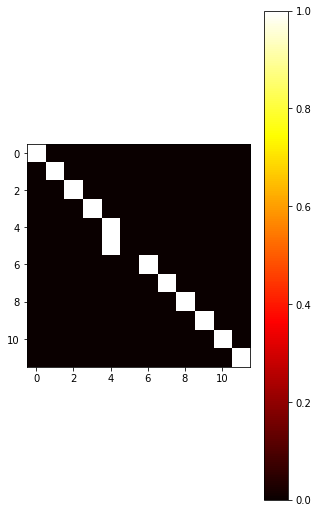

in: 
拘我无非胸少墨
model answer: 
随他自是梦千回
desired answer: 
伤人最是话藏刀




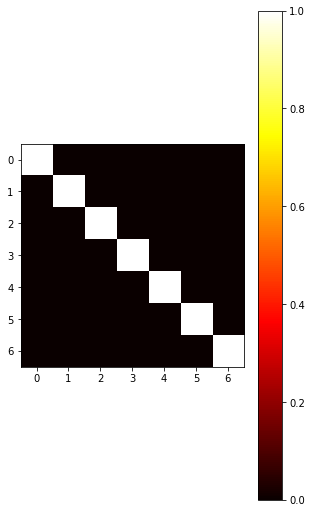

in: 
处变无惊真胆大
model answer: 
人来有道不言行
desired answer: 
怀才不遇好心酸




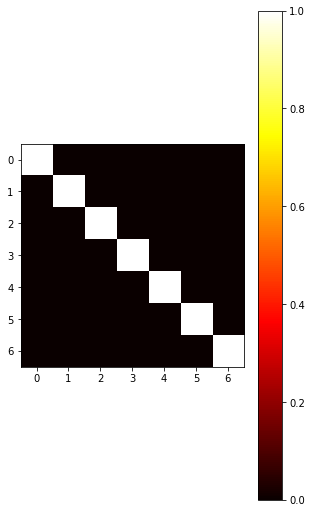

in: 
寂寞寒窗空守寡
model answer: 
浩浩瀚海浪淘沙
desired answer: 
娉婷妙姹妄妃婚




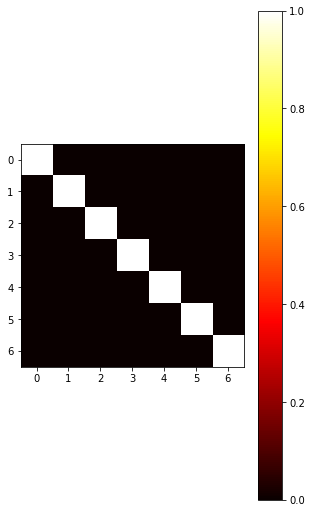

in: 
盛世人和，少长成集扬国粹
model answer: 
新春景秀，新春焕彩绘华章
desired answer: 
名城时泰，群贤毕至聚南昌




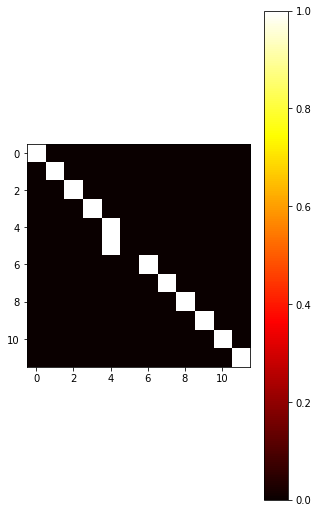

in: 
秋空连碧海
model answer: 
春色染红霞
desired answer: 
昼雨湿青山




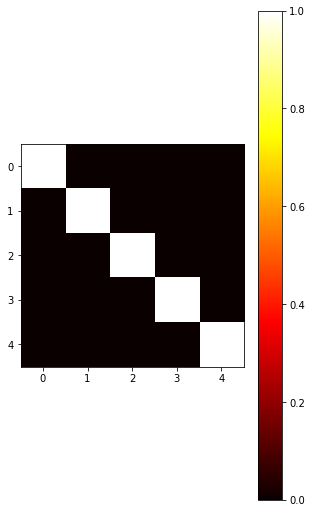

in: 
要侃要侃要侃偏要侃，谁侃都要侃
model answer: 
精神精神精神也精神，我神帝精神
desired answer: 
不说不说不说就不说，你说也不说




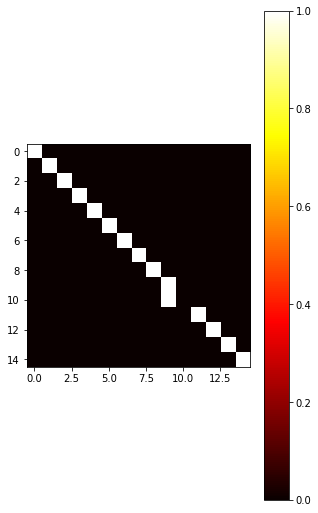

in: 
书山漫步开慧眼
model answer: 
法海频频架金桥
desired answer: 
乐海泛舟渡静心




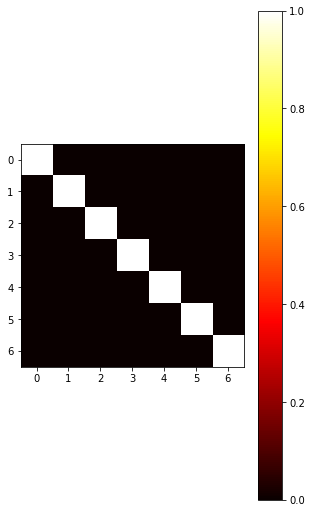

in: 
天公添乱，天然福岛变灾岛
model answer: 
地煞害人，地道神州遭祸州
desired answer: 
地震递升，地表东京成难京




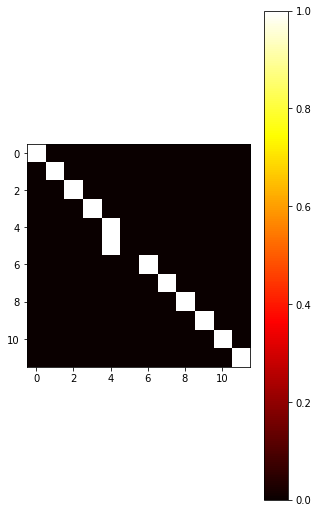

in: 
九如雅韵心常泰
model answer: 
三届天香气愈昂
desired answer: 
一味禅茶意永春




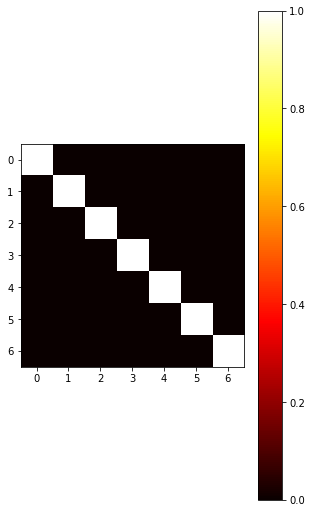

in: 
玉烛
model answer: 
金光
desired answer: 
冰壶




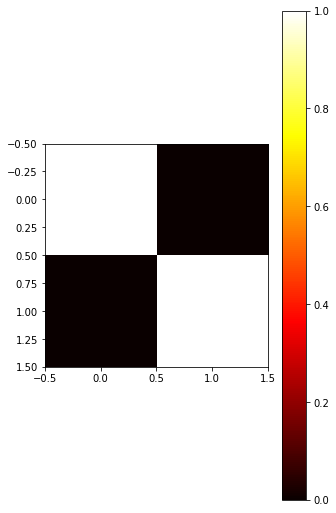

in: 
大雄流佛韵
model answer: 
微信聚人心
desired answer: 
宝殿泛春光




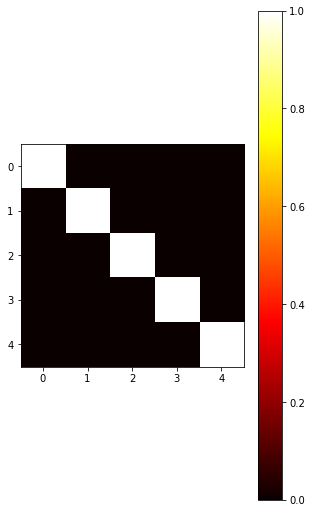

in: 
灯影憧憧，凄绝暗风吹雨夜
model answer: 
电波怒怒，洋洋洋水送温馨
desired answer: 
荻花瑟瑟，魂销明月满船时




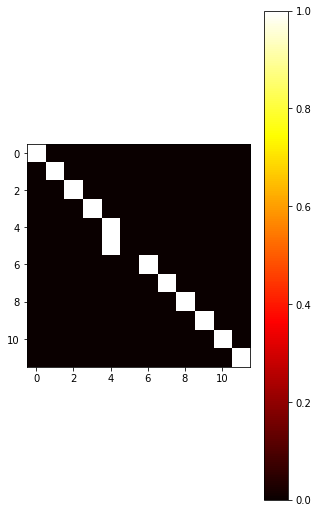

in: 
永定河溪流澈洌，卢沟桥晓月当空，可诗可画千年韵
model answer: 
清凉岁月矗丰碑，瓦舍地丰功酿美，以史以铭万古风
desired answer: 
宛平城色彩缤纷，园博会奇葩竞秀，宜业宜居万户春




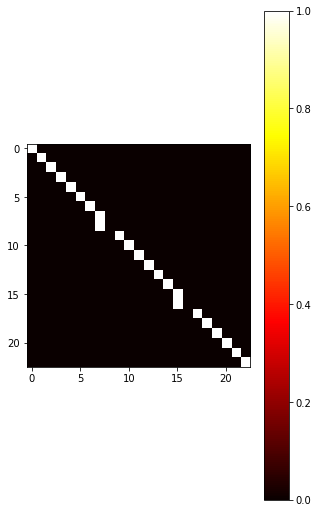

in: 
烟柳江南，婀娜提篮女
model answer: 
清香世上，婆妈妈祖妈
desired answer: 
桃花渡口，风流骑马郎




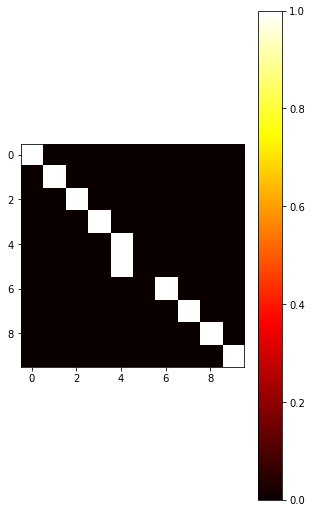

in: 
大圣登天回上界
model answer: 
嫦娥奔月上高楼
desired answer: 
金鸡接任到神州




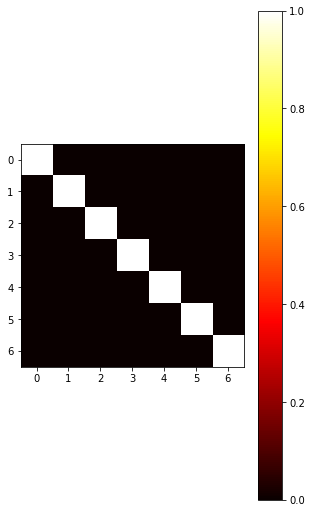

in: 
大地绿丰精品质
model answer: 
中天红日大文章
desired answer: 
小村人杰广经营




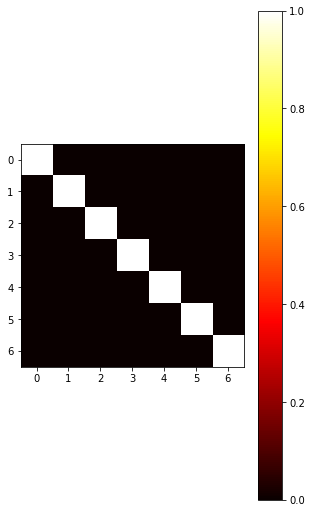

in: 
九域诗章春寄韵
model answer: 
一生笔墨月随风
desired answer: 
千秋画卷彩朝阳




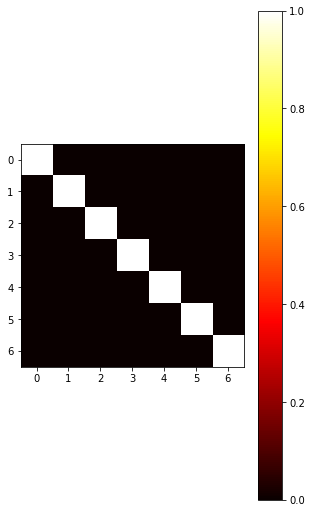

in: 
斗鸡山上山鸡斗
model answer: 
飞鹤洞中洞鹤飞
desired answer: 
林隐寺中寺隐林




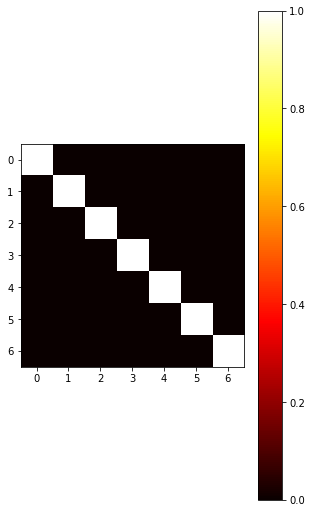

in: 
志存银汉碧云，酿成诗骨四君子
model answer: 
心系金瓯皓月，赢得春光一女人
desired answer: 
信守青畴白水，醉入松风半月台




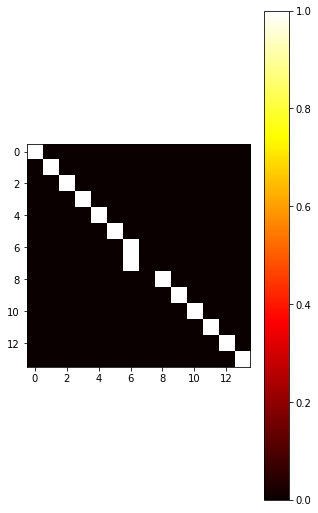

in: 
失意杯酒藉
model answer: 
无情水云天
desired answer: 
寂寞红颜慰




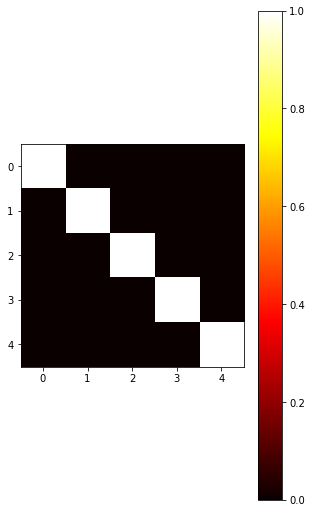

in: 
百族
model answer: 
千秋
desired answer: 
三农




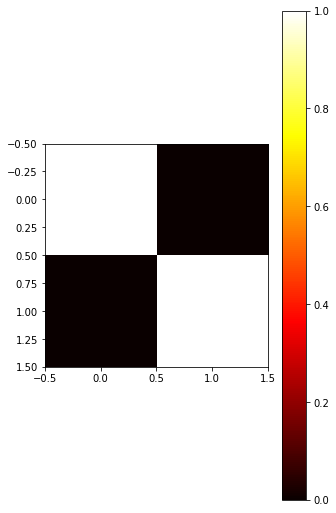

in: 
一派青峰，峰峰素韵源天地
model answer: 
千秋明月，月月幽幽隐古今
desired answer: 
诸般丽景，景景奇观出自然




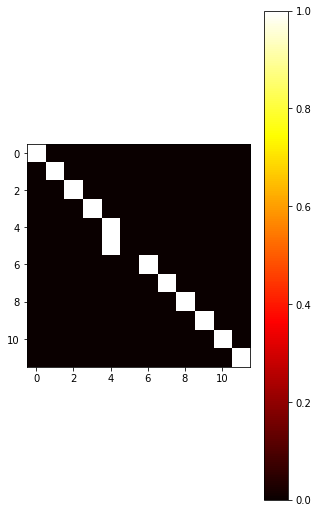

in: 
涧水陶情心不老
model answer: 
春山入画意无穷
desired answer: 
参花惬意味无穷




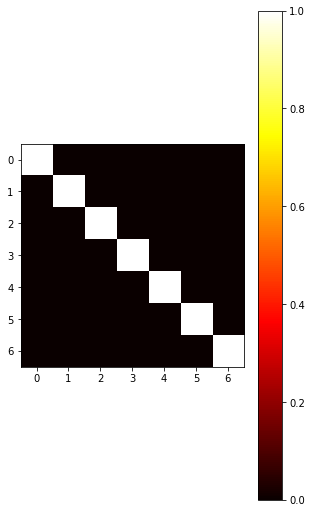

in: 
天道酬勤，金榜题名终遂愿
model answer: 
春风得意，兰舟载誉自成名
desired answer: 
羊羔跪乳，乌鸦哺母且思恩




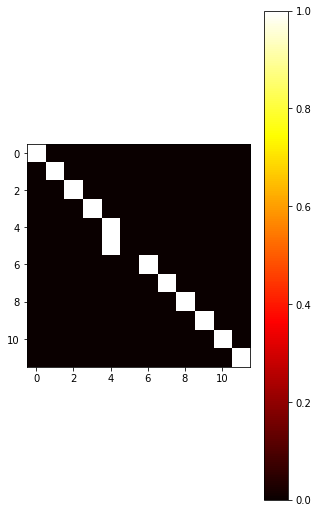

in: 
甘甜堪适口
model answer: 
淡泊自安心
desired answer: 
香味欲醒牙




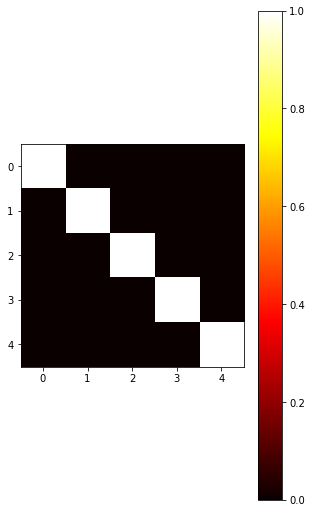

in: 
童子骑牛闻酒气
model answer: 
老娘缝马觅书香
desired answer: 
老翁博弈品茶香




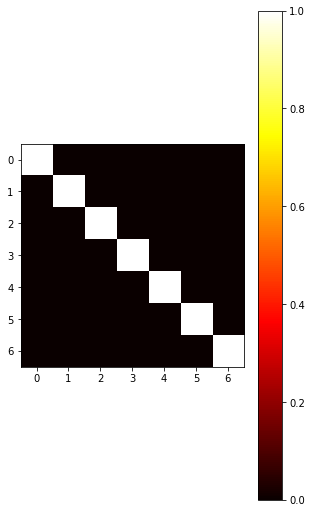

in: 
春宠三分调柳色
model answer: 
夏荷一点下荷香
desired answer: 
冬求一醉觅梅花




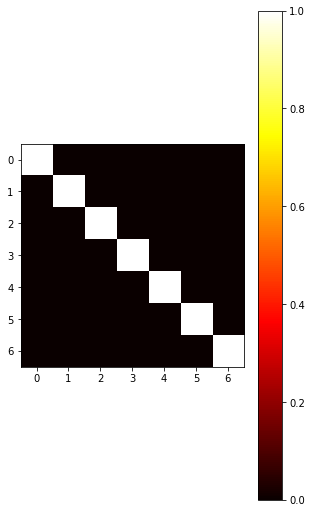

in: 
桃李吟春绿
model answer: 
松筠映日红
desired answer: 
山川映夏青




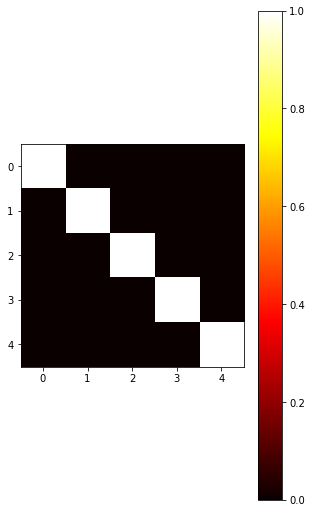

in: 
今逢逆境欣相勉
model answer: 
何必良辰倍相期
desired answer: 
幸遇知音倍觉亲




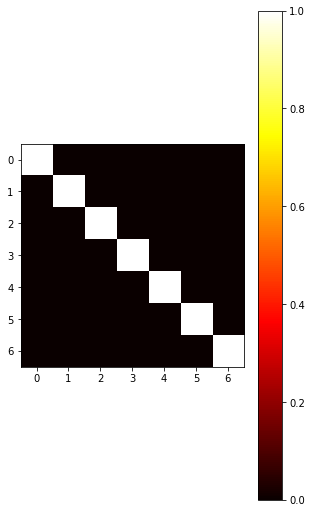

in: 
神岳居高，统华岱衡恒，险峻横天峰七二
model answer: 
圣贤在此，传中华崛起，巍巍拔地祀百年
desired answer: 
名山叠厚，集僧儒道帝，人文载物墨三千




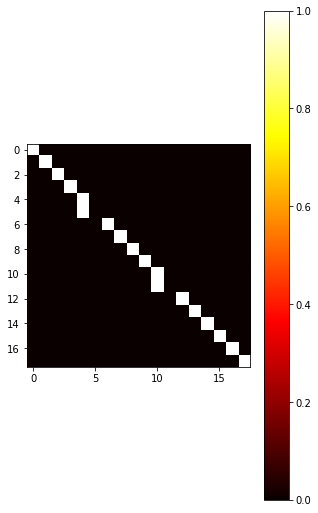

in: 
春心已破，墨色犹香，忍令淡烟吹寒露
model answer: 
秋意渐消，蛩声已远，抬头孤影冷空巢
desired answer: 
雁信难收，婵娟易悔，空留明月向中秋




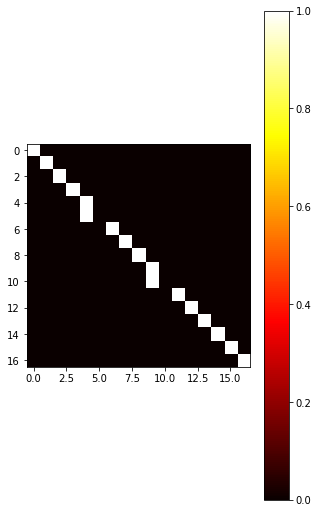

in: 
志士心欢，中华国泰
model answer: 
贤人志壮，世泰春和
desired answer: 
昊天日丽，大地春新




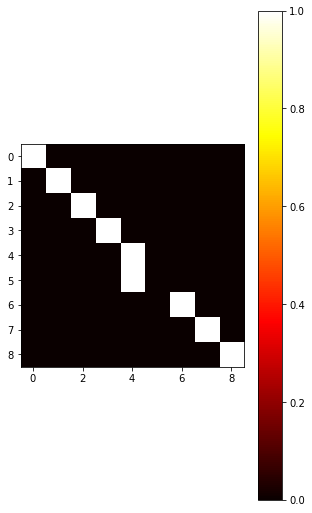

in: 
岁月流诗，奋蹄快马催春步
model answer: 
风云际会，昂首豪情壮国威
desired answer: 
城乡绘画，振翅大方赴锦程




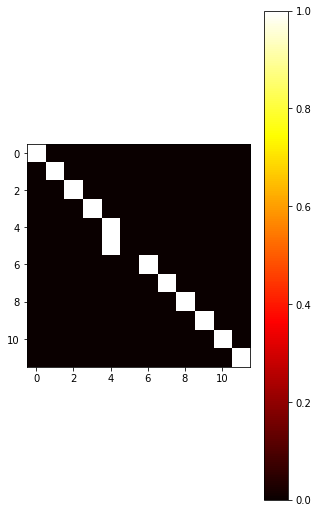

in: 
秋蝉一去无回客
model answer: 
春燕双飞有意人
desired answer: 
月兔千年不老身




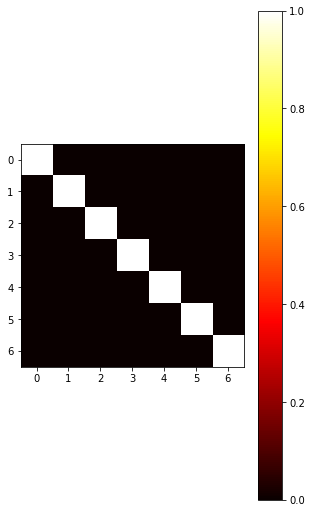

in: 
别酒心先醉
model answer: 
离愁梦已空
desired answer: 
去舟泪已潸




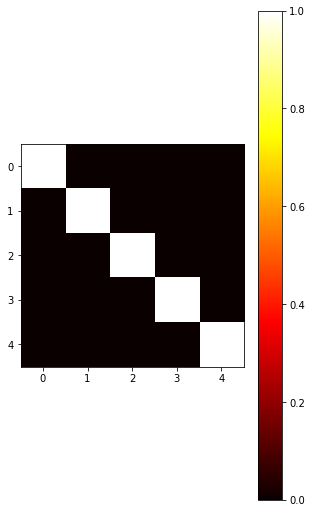

in: 
泉涌乡情珠串串
model answer: 
潭开水色画图图
desired answer: 
天开玉镜影幢幢




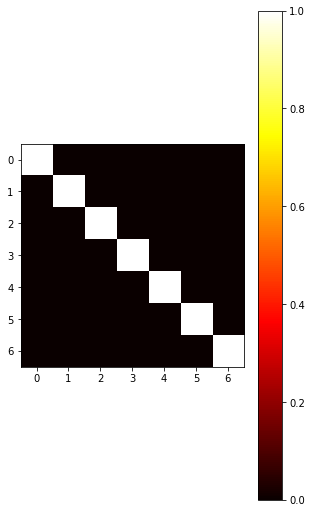

in: 
春莲夏柳珊瑚树
model answer: 
春晓春风锦绣帏
desired answer: 
青地黄瓜栗豆藤




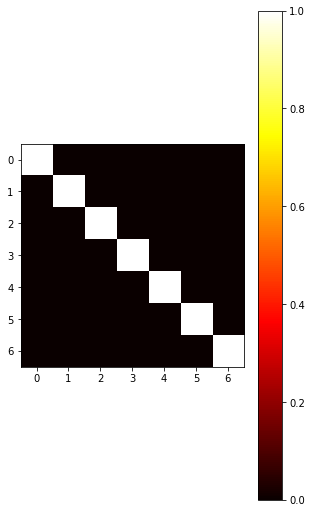

in: 
一入江湖难罢酒
model answer: 
无来岁月不饶人
desired answer: 
附庸风雅乱吟诗




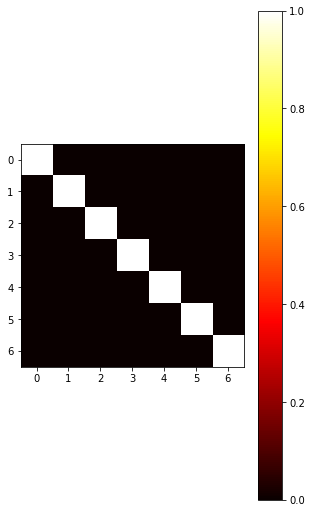

in: 
宁可独居，不交愚伴
model answer: 
倘如此事，无虑大同
desired answer: 
欲求正道，莫信邪师




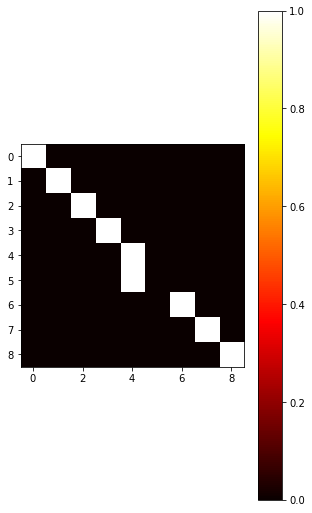

in: 
大药轩黄先后圣
model answer: 
晟人日暖早成仙
desired answer: 
垂杨亭碧古今情




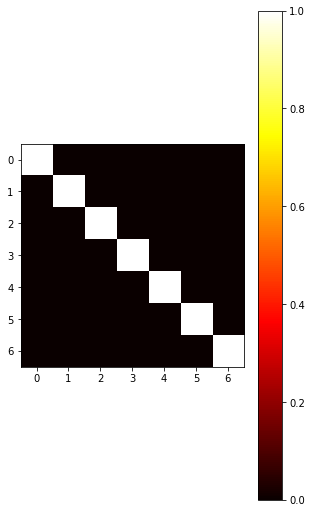

in: 
五福临门，五环旗映五星闪
model answer: 
八方进院，八里春铺八域开
desired answer: 
百川归海，百姓家和百事兴




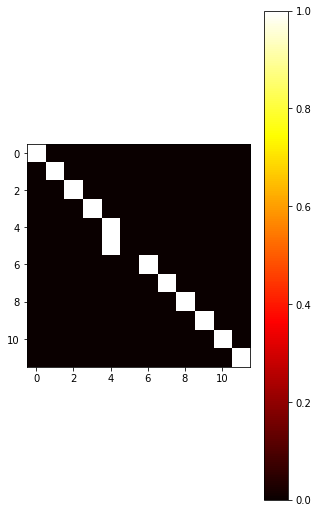

in: 
出海眼无冬无夏
model answer: 
入门心有我有谁
desired answer: 
泛波心有温有凉




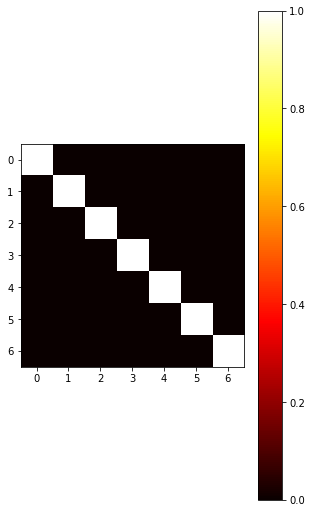

in: 
程门立雪予来晚
model answer: 
驿路梅花为点红
desired answer: 
玉宇乘风公觉先




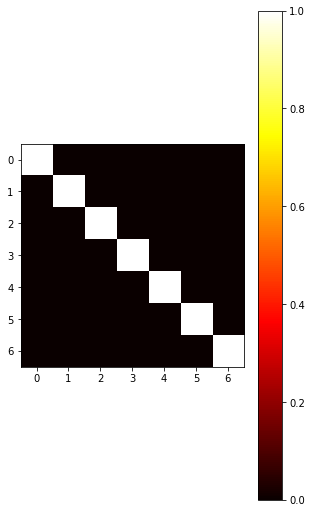

in: 
五谷满仓，一江通海，万木争春，绍古更千帆竞发
model answer: 
三阳开泰，百业兴邦，百花竞艳，迎新迎万马腾飞
desired answer: 
太山空壁，两岸透尘，几心醉梦，革新须百鸟高飞




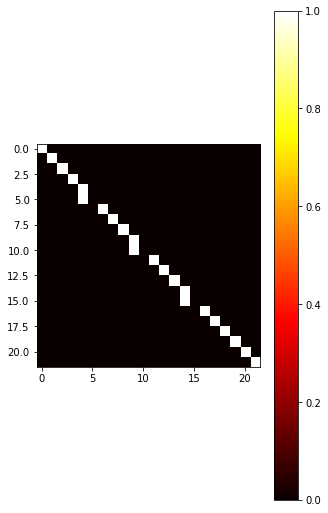

in: 
皇路方清，俊士并起
model answer: 
古城不老，帝王共和
desired answer: 
圣经咸在，大义以明




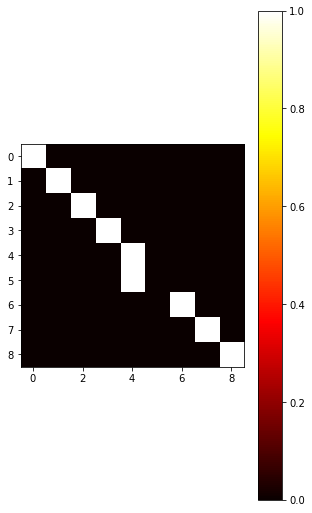

in: 
牛耕九野
model answer: 
虎跃千山
desired answer: 
虎啸八方




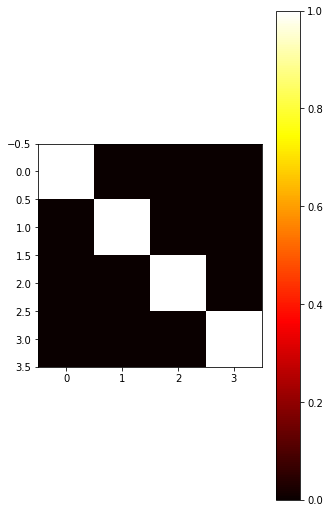

in: 
月明沧海阔
model answer: 
风靡碧溟濛
desired answer: 
柳暗红尘远




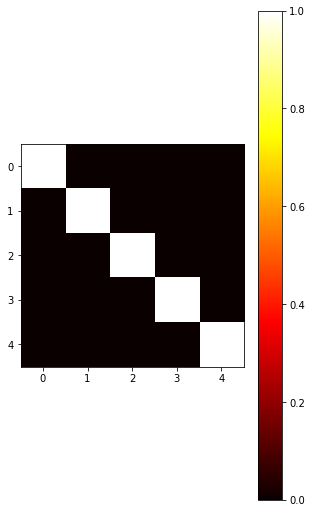

in: 
衣袖一挥云彩落
model answer: 
诗文满载月华升
desired answer: 
对联百会艺文传




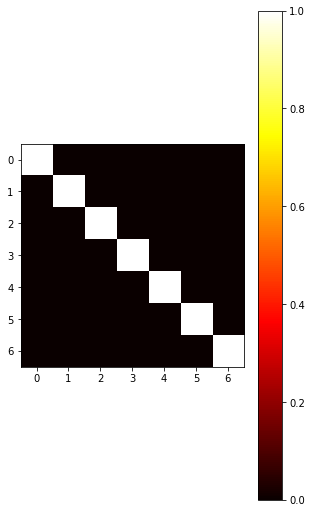

in: 
性癖诗词，不废朝吟夕诵
model answer: 
心闲意志，何妨处比天人
desired answer: 
肩挑使命，还须志洁行廉




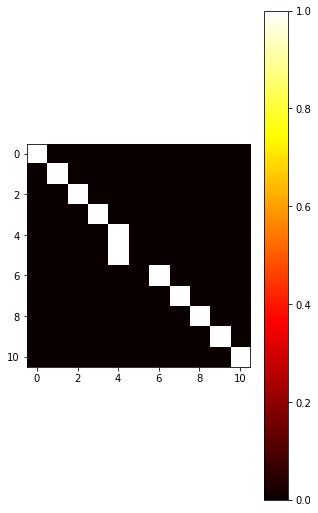

in: 
隔代遗传孙像祖
model answer: 
当年喻世汉家人
desired answer: 
近亲结合貌离神




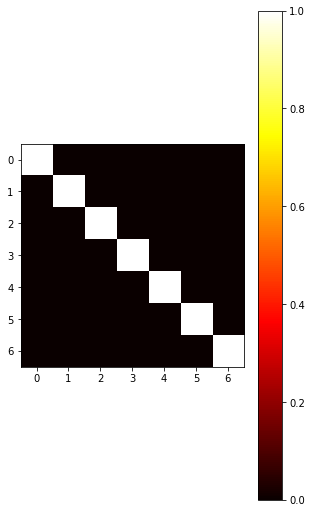

in: 
虎步扬威腾骏业
model answer: 
兔毫蘸彩绘春光
desired answer: 
兔毫蘸彩绘鸿图




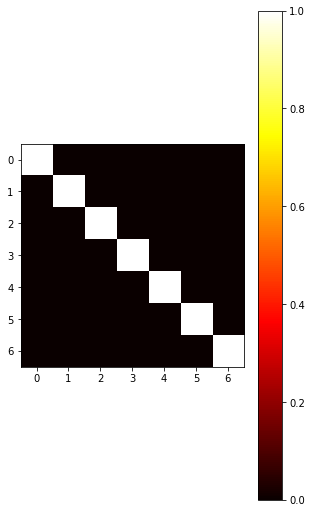

in: 
春来且纵疏狂笔
model answer: 
夏去方知寂寞心
desired answer: 
冬去该迎烂漫花




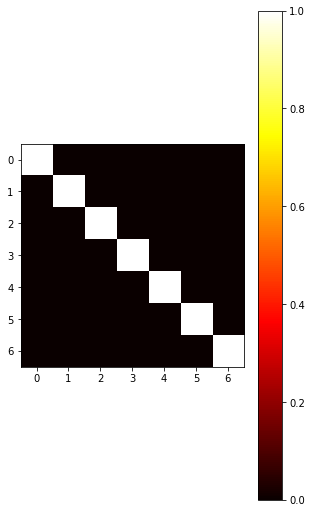

in: 
三秋绝塞奉哀音，自怜絮酒生刍，道远无方能缩地
model answer: 
一世名山留余韵，不愧名山留水，名高其古可传人
desired answer: 
廿载离群怀旧好，同是春晖寸草，年来有恨各终天




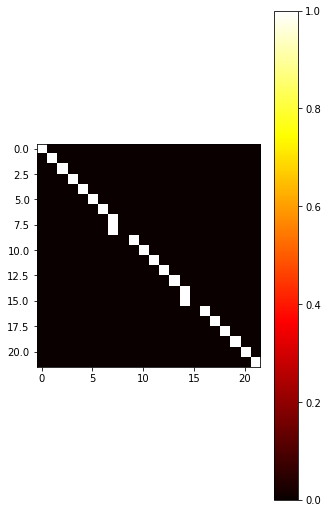

in: 
风雨起南湖，点亮明灯一盏
model answer: 
春光腾北斗，铺开画卷千张
desired answer: 
雪冰封北国，写成绝唱千秋




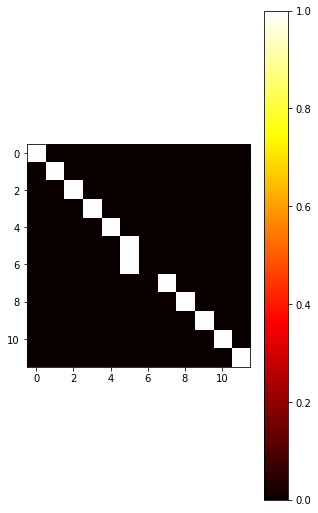

in: 
循石级而登，云绕月浮，举步即通紫阙
model answer: 
置玄机以坐，月临山迥，临风不入青冥
desired answer: 
俯红尘以望，声喧影杂，问人几醒黄粱




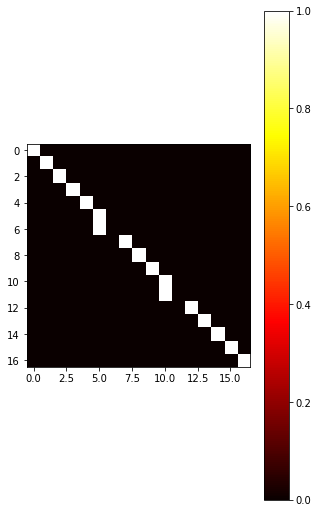

in: 
交浅言深为大忌
model answer: 
室宽室雅待清闲
desired answer: 
情真意实是知音




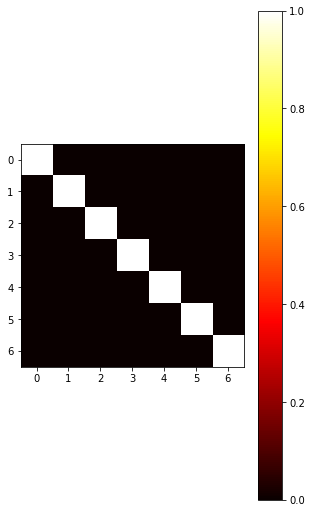

in: 
申奥强身圆美梦
model answer: 
迎春接力拓新程
desired answer: 
兴华报国奋雄程




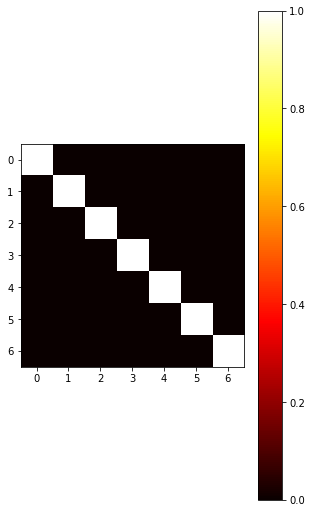

in: 
金桂感恩，香随鸿雁落宝刹
model answer: 
峰峦滴翠，水自清流生古人
desired answer: 
云霞承惠，霭罩琴台结良缘




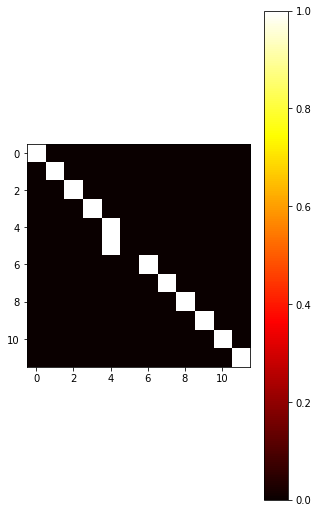

in: 
领引潮流名远播
model answer: 
先行道义道长行
desired answer: 
先行始创志凌空




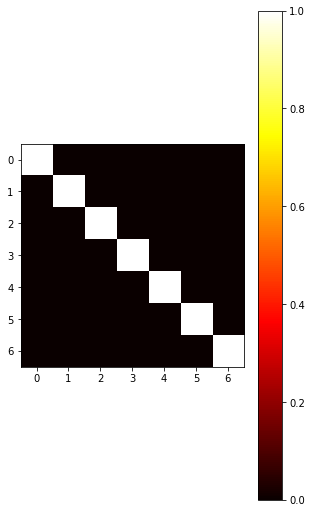

in: 
出门便是青山客
model answer: 
入室当然明月心
desired answer: 
移步恍如流水兵




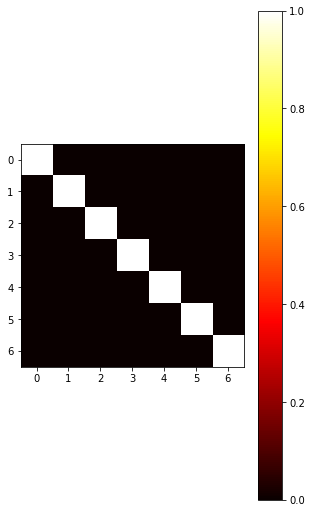

in: 
身后春秋多杂志
model answer: 
眼前岁月少知音
desired answer: 
生前主产别更名




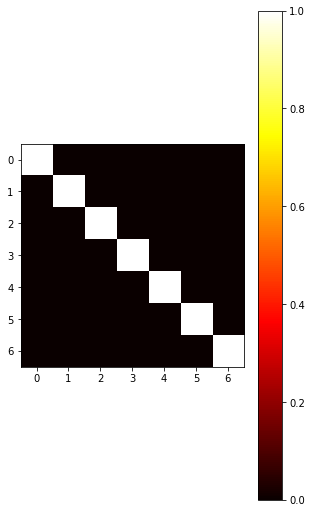

in: 
英雄不问出身，大明天子，曾当和尚
model answer: 
皇帝何堪为己？古尸古人？可有大王
desired answer: 
统帅或因时势，中共主席，做过老师




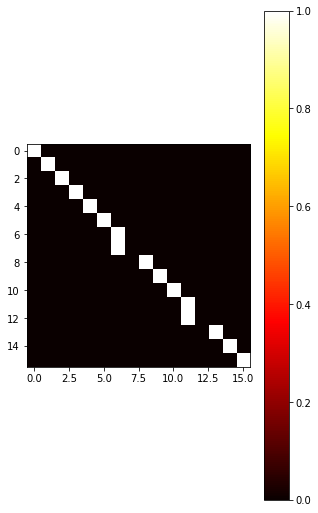

in: 
沉鱼落雁，闭月羞花，因何四美传千古
model answer: 
救母救人，扶伤救苦，不负一心叹万年
desired answer: 
复越和番，锄奸殉国，是故多情动九州




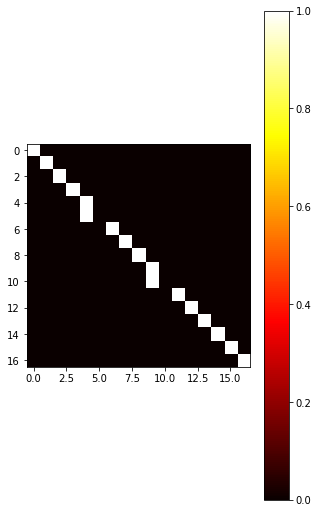

in: 
得句当风立
model answer: 
吟诗作月眠
desired answer: 
开函对月吟




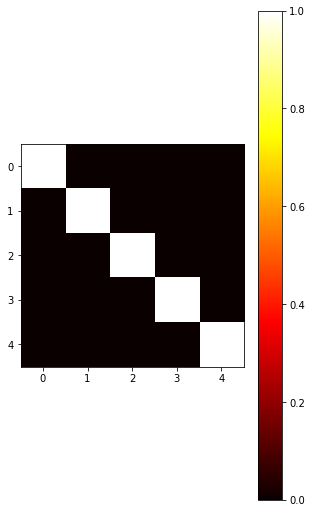

in: 
时势英雄皆过往，廿年胜败殊途，史话犹传，古来烽火劫灰在
model answer: 
死生子女尽牺牲，一代悲伤旧部，诗书难改，今作良师吊脚为
desired answer: 
人间风物记沧桑，几度江山易主，民心渐冷，莫教生灵涂炭多




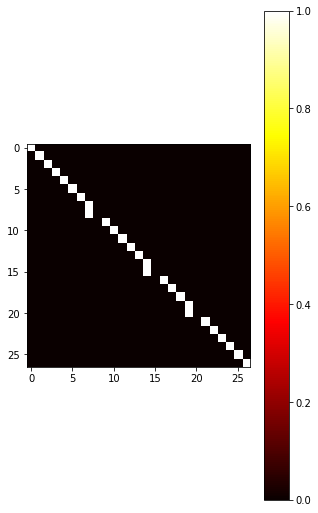

in: 
飞花几笔春心事
model answer: 
落叶一笺秋意诗
desired answer: 
大雪漫天梅精神




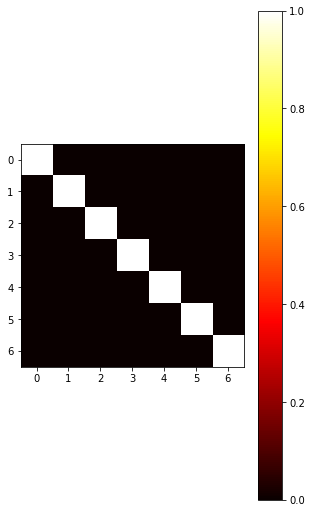

in: 
让百姓放心，严防身病添心病
model answer: 
教九州追梦，奋力精神励梦神
desired answer: 
督药商守法，长使行规遵法规




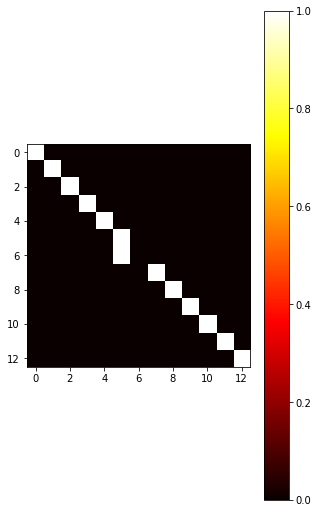

in: 
床底下放鹞子
model answer: 
座中间罢莲花
desired answer: 
云端里出批头




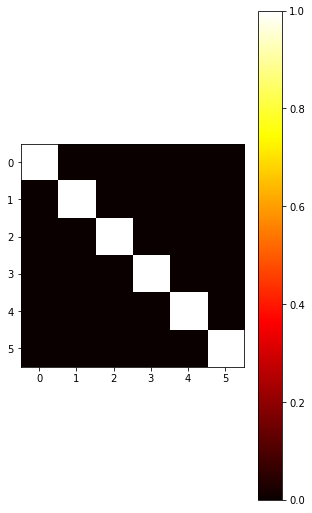

in: 
凉意生竹树
model answer: 
热情伴月斋
desired answer: 
疏雨滴梧桐




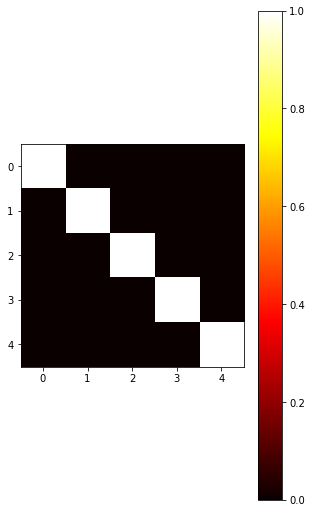

in: 
日暖风和，燕莺入画，拥翠岭白云，唱渔歌几曲
model answer: 
山明水秀，山水流霞，看青山绿水，摇桨弄波澜
desired answer: 
鱼肥草美，山水迷人，钓闲情快意，执雅趣一竿




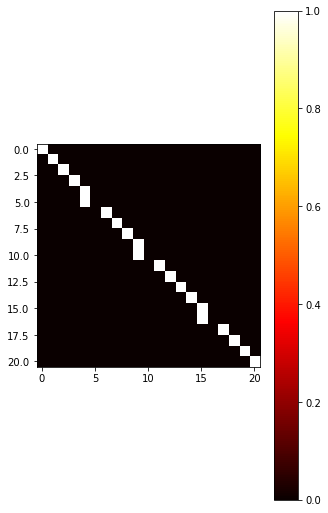

In [12]:
evaluateRandomly(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=1,n=200)

In [20]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=1,n=len(batch_in_out_pairs_eval))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
## FIN ##
BLEU : 0.17173033244710195
#count >0.2 : 4.0


In [16]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=3,n=len(batch_in_out_pairs_eval))

0.0


NameError: name 'device' is not defined

In [54]:
# 203
compute_bleu(char2tone_dict,encoder, attn_decoder,forced_tone=True,forced_word=True,beam_width=5,n=len(batch_in_out_pairs_eval))

0.0
0.09997456118036123
0.19994912236072246
0.2999236835410837
0.3998982447214449
0.49987280590180616
0.5998473670821673
0.6998219282625286
0.7997964894428898
0.8997710506232511
0.9997456118036123
## FIN ##
BLEU : 0.13732333521721898
#count >0.2 : 1146.6
